### TERCERA VERSIÓN DE MODELAJE


In [1]:
#carga librerias python 
#import librerias necesarias 
import pickle
from sklearn import preprocessing as prep
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,explained_variance_score
from sklearn.metrics import roc_auc_score, confusion_matrix, silhouette_score,silhouette_samples
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import *
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pprint import pprint
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV 
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
import pickle
from sklearn.model_selection import *
from sklearn.ensemble import GradientBoostingClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
#carga base de datos completa
df = pd.read_csv("base_reentrenamiento_2020_new.csv",header = 0, sep = ';')

In [3]:
#base de entrenamiento. se seleccionan 4 años los cuáles recogen suficiente historia de clientes en banistmo.
df_entrenar = df[(df.fecha>=201407) & (df.fecha<=201807)]

In [4]:
df_entrenar.shape

(4398017, 39)

### Premora
- con el fin de evaluar el rendimiento de este modelo en clientes con moras entre 1 y 30 se crea la valiable binaria premora_ok, uno esta en ese rango cero de lo contrario. Esto se hace debido a la necesidad específica de que el modelo entienda el comportamiento de estos clientes en partícular debido a su importancia para el negocio.
- con la creación de esta variable se dejan una muestra de estos clientes fuera del entrenamiento del modelo y se valida su comportamiento en dicha muestra de validación.

In [5]:
df_entrenar['premora_ok'] = np.where((df_entrenar.atm_fa_cont >= 1) & (df_entrenar.atm_fa_cont < 31),1,0)

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
df_entrenar.groupby('premora_ok')['id'].nunique()

premora_ok
0    164160
1     76403
Name: id, dtype: int64

In [7]:
df_entrenar.head()

,fecha,id,atm_fa_cont,marca_rodamiento,marca_huesped_pura,marca_perdio_ddir,marca_mora_sup_61,cast_fa,ddir_cliente,saldok,...,atm_fa_cont_90_12m,cast_12m,default_90_12m,repr_ddir_cliente_3m,repr_ddir_cliente_12m,repr_mora_sup_61_12m,repr_rodamientos_12m,repr_huesped_pura_cliente_12m,nonull_ult12,premora_ok
1,201602,264349,0,0,0,0,0,0,0,1113.87,...,18,0,0,0.0,0.0,0.083333,0.25,0.0,12,0
2,201806,367623,53,0,0,0,0,0,1,13726.96,...,174,1,1,1.0,1.0,0.000000,0.00,0.0,12,0
3,201409,288289,0,0,0,0,0,0,1,8382.70,...,0,0,0,1.0,1.0,0.000000,0.00,0.0,12,0
4,201804,98569158,0,0,0,0,0,0,0,5470.15,...,1,0,0,0.0,0.0,0.000000,0.25,0.0,12,0
6,201607,443959,0,0,0,0,0,0,1,25119.00,...,0,0,0,1.0,1.0,0.000000,0.00,0.0,12,0


El pico más bajo en las tasas se presenta en 201502 correspondiente a 8.5% desde dicha fecha comienza un incremento y tiene una estabilización desde comienzos de 201602

### Modelación
inicialmente se tomará una muestra aleaoria de clientes de premora en la historia, esto con el fin de tener un set de validación adicional para estos clientes y poder probar el modelo en dicha muestra y tener así un criterio de decisión mejor a la hora de seleccionar el modelo final

In [8]:
df0 = df_entrenar.copy()
df0["fecha"] = pd.to_datetime(df0['fecha'].apply(lambda x: str(x)[:4]+"-"+str(x)[-2:]), format='%Y-%m')

In [9]:
list_usar = ['id',
'atm_fa_cont',
'marca_huesped_pura',
'ddir_cliente',
'saldok',
'cnt_b2b',
'cnt_auto',
'cnt_pp',
'cnt_sob',
'cnt_tdc',
'max_madurez_b2b',
'max_madurez_auto',
'max_madurez_pp',
'max_madurez_sob',
'max_madurez_tdc',
'madurez',
'std_atm_fa_6m',
'prom_atm_fa_3m',
'repr_rodamientos_12m',
'std_atm_fa_12m',
'prom_atm_fa_12m',
'marca_rodamiento',
'repr_ddir_cliente_12m',
'vari_atm_fp0_12m',
'marca_mora_sup_61',
'vari_atm_fp0_6m',
'prom_atm_fa_6m',
'marca_perdio_ddir',
'std_atm_fa_3m',
'vari_atm_fp0_3m',
'nonull_ult12',
'repr_mora_sup_61_12m',
'premora_ok',
'default_90_12m']

In [10]:
df_var_ini = df0[list_usar].copy()

### Base Validación Clientes Premora 

In [11]:
# separar clientes con premora_ok =1 y =0
id_premora_ok_1 = df_var_ini.id[df_var_ini["premora_ok"] == 1] 
id_premora_ok_0 = df_var_ini.id[df_var_ini["premora_ok"] == 0] #sobrepoblada en condiciones normal

In [12]:
N = 0.004

In [13]:
# calcular el tamaño de cada subset premora_ok =1 y =0 y sacarle el 5% de cada uno
size_premora_ok_1 = int(len(id_premora_ok_1)*N)
size_premora_ok_0 = int(len(id_premora_ok_0)*N)

In [14]:
# muestrar 5% de cada cada subset premora_ok =1 y =0
sample_premora_ok_1 = np.random.choice(id_premora_ok_1,size_premora_ok_1).tolist()
sample_premora_ok_0 = np.random.choice(id_premora_ok_0,size_premora_ok_0).tolist()

In [15]:
#juntar ambos en un solo dataframe que es el validation set final
df_validation = df0[df0.id.isin(sample_premora_ok_0 + sample_premora_ok_1)]

In [16]:
100*df_validation.id.unique().shape[0]/df_var_ini.id.unique().shape[0]

9.945604278724892

In [17]:
df_validation = df_validation[['id',"fecha",
'atm_fa_cont',
'marca_huesped_pura',
'ddir_cliente',
'saldok',
'cnt_b2b',
'cnt_auto',
'cnt_pp',
'cnt_sob',
'cnt_tdc',
'max_madurez_b2b',
'max_madurez_auto',
'max_madurez_pp',
'max_madurez_sob',
'max_madurez_tdc',
'madurez',
'std_atm_fa_6m',
'prom_atm_fa_3m',
'repr_rodamientos_12m',
'std_atm_fa_12m',
'prom_atm_fa_12m',
'marca_rodamiento',
'repr_ddir_cliente_12m',
'vari_atm_fp0_12m',
'marca_mora_sup_61',
'vari_atm_fp0_6m',
'prom_atm_fa_6m',
'marca_perdio_ddir',
'std_atm_fa_3m',
'vari_atm_fp0_3m',
'nonull_ult12',
'repr_mora_sup_61_12m',
'premora_ok',
'default_90_12m']]

In [18]:
unique_dates = df0.fecha.unique()
unique_dates.sort()
print(unique_dates)

['2014-07-01T00:00:00.000000000' '2014-08-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2016-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2016-12-01T00:00:00.000000000'
 '2017-01-01T00:00:00.000

### Base de Entrenamiento

In [19]:
df_train_cv = df0[~df0.id.isin(sample_premora_ok_0 + sample_premora_ok_1)]

In [20]:
df_train_cv.premora_ok.value_counts()/df_train_cv.premora_ok.shape[0]

0    0.92318
1    0.07682
Name: premora_ok, dtype: float64

In [21]:
df_train_cv = df_train_cv [['id',"fecha",
'atm_fa_cont',
'marca_huesped_pura',
'ddir_cliente',
'saldok',
'cnt_b2b',
'cnt_auto',
'cnt_pp',
'cnt_sob',
'cnt_tdc',
'max_madurez_b2b',
'max_madurez_auto',
'max_madurez_pp',
'max_madurez_sob',
'max_madurez_tdc',
'madurez',
'std_atm_fa_6m',
'prom_atm_fa_3m',
'repr_rodamientos_12m',
'std_atm_fa_12m',
'prom_atm_fa_12m',
'marca_rodamiento',
'repr_ddir_cliente_12m',
'vari_atm_fp0_12m',
'marca_mora_sup_61',
'vari_atm_fp0_6m',
'prom_atm_fa_6m',
'marca_perdio_ddir',
'std_atm_fa_3m',
'vari_atm_fp0_3m',
'nonull_ult12',
'repr_mora_sup_61_12m',
'premora_ok',
'default_90_12m']]

### Train-Validation

In [22]:
Y_train_cv, X_train_cv = df_train_cv.default_90_12m, df_train_cv#.drop(["default_90_12m","fecha"], axis=1)
Y_validation, X_validation = df_validation.default_90_12m, df_validation#.drop(["default_90_12m","fecha"], axis=1)


In [23]:
X_train_cv_final = X_train_cv.copy()
inner_cv_groups = X_train_cv_final["id"]
inner_cv_groups_gkf = X_train_cv_final["id"]
inner_cv_groups_lpgo = X_train_cv_final["premora_ok"]

X_train_cv_final.drop(["id","default_90_12m","fecha", "premora_ok"], axis=1, inplace=True)

In [24]:
X_validation_final = X_validation.copy()
outer_cv_groups = X_validation_final["id"]
outer_cv_groups_gkf = X_validation_final["id"]
outer_cv_groups_lpgo = X_validation_final["premora_ok"]

X_validation_final.drop(["id","default_90_12m","fecha", "premora_ok"], axis=1, inplace=True)

In [25]:
X_train_cv_cols = X_train_cv.columns
X_train_cv_cols = X_validation.columns

In [26]:
print(Y_train_cv.shape)
print(Y_validation.shape)

(3793114,)
(604903,)


In [27]:
print(X_train_cv_final.shape)
print(X_validation_final.shape)

(3793114, 31)
(604903, 31)


In [28]:
Y_train_cv.value_counts()/Y_train_cv.count()

0    0.891934
1    0.108066
Name: default_90_12m, dtype: float64

In [29]:
Y_validation.value_counts()/Y_validation.count()

0    0.935085
1    0.064915
Name: default_90_12m, dtype: float64

### Set Modelo

In [30]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score
import pickle
from sklearn.model_selection import *
from sklearn.ensemble import GradientBoostingClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [31]:
param_grid = {"loss":["binary_crossentropy"],
                "learning_rate": [0.01,0.1],
                "max_iter": np.arange(16,48,8), 
                "max_leaf_nodes":np.arange(10,50,10), 
                "max_depth":np.arange(20,100,5), 
                "min_samples_leaf":np.arange(50,100,10), 
                "l2_regularization":[0.2,0.8],
                "max_bins":[255], 
                "monotonic_cst":[None], 
                "early_stopping":['auto'], 
                "scoring":['loss'], 
                "validation_fraction":[0.1, 0.3], 
                "n_iter_no_change":[10], 
                "tol":[1e-07]
             }

In [32]:
NUM_TRIALS = 5
# Arrays to store scores
outer_scores = np.zeros(NUM_TRIALS)
inner_scores = np.zeros(NUM_TRIALS)

In [33]:
scoring = {"AUC": "roc_auc",
           "balanced_accuracy": make_scorer(balanced_accuracy_score)}

In [34]:
TAG = "FINAL"

In [35]:
import time
inner_models = list()
for i in range(NUM_TRIALS):
    inner_cv = GroupKFold(n_splits = 3)
    outer_cv = GroupKFold(n_splits = 2)
    
    inner_cv_indexes = list(inner_cv.split(X_train_cv_final, 
                                           Y_train_cv, 
                                           inner_cv_groups))     
    
    # Non_nested parameter search and scoring
    base_estimator = HistGradientBoostingClassifier(random_state = i)
    
    inner_clf = RandomizedSearchCV(estimator=base_estimator,
                               param_distributions = param_grid,
                               cv = inner_cv_indexes,
                               n_iter = 10,
                               scoring = scoring,
                               refit = "AUC",
                               return_train_score = True,
                               random_state = i,
                               n_jobs = -1)
    
    print("inner cv: ", i)
    inner_start = time.time()
    inner_clf.fit(X_train_cv_final, Y_train_cv)
    inner_end = time.time()
    print("inner elapsed: {}".format(inner_end-inner_start))
    inner_scores[i] = inner_clf.best_score_

    
   #save inner_scores
    fname_inner_score = "{}_inner_score_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_inner_score, "wb") as f:
        pickle.dump(inner_clf.best_score_, f)


   # save inner_model
    fname_inner_model = "{}_inner_model_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_inner_model, "wb") as f:
        pickle.dump(inner_clf.best_estimator_, f)
 
    inner_models.append(inner_clf.best_estimator_)
 

 

    print("outer_cv: ", i)
    outer_start = time.time()
    outer_clf = cross_val_score(inner_clf.best_estimator_, 
                                X = X_validation_final, 
                                y = Y_validation, 
                                cv=outer_cv,
                                groups = outer_cv_groups,
                                n_jobs = -1)
    outer_end = time.time()
    print("outer elapsed: {}".format(outer_end-outer_start))
    outer_scores[i] = outer_clf.mean()
    
    print("inner score: {}".format(inner_clf.best_score_))
    print("outer score: {}".format( outer_clf.mean()))
    
   # save iouter_score
    fname_outer_score = "{}_outer_score_trial_{}_{}".format(TAG, i,".sav")
    with open(fname_outer_score, "wb") as f:
        pickle.dump(outer_clf.mean(), f)

inner cv:  0
inner elapsed: 356.90731978416443
outer_cv:  0
outer elapsed: 12.028263568878174
inner score: 0.8660253742250292
outer score: 0.943733127634859
inner cv:  1
inner elapsed: 386.35635113716125
outer_cv:  1
outer elapsed: 10.390505313873291
inner score: 0.865968913328163
outer score: 0.9436917983802293
inner cv:  2
inner elapsed: 362.50907158851624
outer_cv:  2
outer elapsed: 9.735743761062622
inner score: 0.8658552013691473
outer score: 0.9438984430354826
inner cv:  3
inner elapsed: 359.03090381622314
outer_cv:  3
outer elapsed: 10.54806399345398
inner score: 0.8672384245031907
outer score: 0.9437480059304004
inner cv:  4
inner elapsed: 373.40168142318726
outer_cv:  4
outer elapsed: 11.435213565826416
inner score: 0.8678239250996814
outer score: 0.9438207447615521


In [36]:
pd.DataFrame([x.get_params() for x in inner_models])

,early_stopping,l2_regularization,learning_rate,loss,max_bins,max_depth,max_iter,max_leaf_nodes,min_samples_leaf,monotonic_cst,n_iter_no_change,random_state,scoring,tol,validation_fraction,verbose,warm_start
0,auto,0.2,0.1,binary_crossentropy,255,45,32,30,90,None,10,0,loss,1.000000e-07,0.1,0,False
1,auto,0.8,0.1,binary_crossentropy,255,20,40,20,60,None,10,1,loss,1.000000e-07,0.3,0,False
2,auto,0.2,0.1,binary_crossentropy,255,85,40,20,50,None,10,2,loss,1.000000e-07,0.1,0,False
3,auto,0.2,0.1,binary_crossentropy,255,20,40,30,80,None,10,3,loss,1.000000e-07,0.3,0,False
4,auto,0.2,0.1,binary_crossentropy,255,50,40,40,90,None,10,4,loss,1.000000e-07,0.1,0,False


In [37]:
#guardar modelos
# save inner_models
filename = TAG + '_inner_models.sav'
pickle.dump(inner_models, open(filename, 'wb'))

In [38]:
#save inner_scores
filename = TAG + '_inner_scores.sav'
pickle.dump(inner_scores, open(filename, 'wb'))

In [39]:
#save_outer_scores
filename = TAG + '_outer_scores.sav'
pickle.dump(outer_scores, open(filename, 'wb'))

In [40]:
# 90% de toda la data 
inner_scores

array([0.86602537, 0.86596891, 0.8658552 , 0.86723842, 0.86782393])

In [41]:
# rendimiento en muestra de validación (premora) 10% de toda la data
outer_scores

array([0.94373313, 0.9436918 , 0.94389844, 0.94374801, 0.94382074])

In [42]:
print(inner_scores.mean(),"+/-",inner_scores.std())
print(outer_scores.mean(),"+/-",outer_scores.std())

0.8665823677050424 +/- 0.000798400172335685
0.9437784239485048 +/- 7.304332055750401e-05


In [43]:
# en los 5 experimentos el validation set tiene mejor score que el train set
score_difference = inner_scores- outer_scores
print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

Average difference of -0.077196 with std. dev. of 0.000796.


In [44]:
score_difference

array([-0.07770775, -0.07772289, -0.07804324, -0.07650958, -0.07599682])

<Figure size 864x864 with 0 Axes>

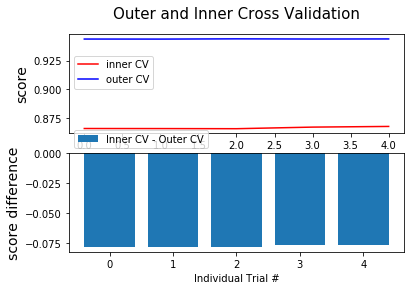

In [45]:
# Plot scores on each trial for nested and non-nested CV
plt.figure(figsize=(12,12))
plt.figure()
plt.subplot(211)
inner_scores_line, = plt.plot(inner_scores, color='r')
outer_line, = plt.plot(outer_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([inner_scores_line, outer_line],
           ["inner CV", "outer CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Outer and Inner Cross Validation",
          x=.5, y=1.1, fontsize="15")
# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Inner CV - Outer CV"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")
plt.show()

#### Stattistical difference between a change score and zero.
- This approach involves creating a change score from two variables, and then comparing the mean change score to zero, which will indicate whether any change accurred between the two time points for the original measures. If the mean change score is not significantly different from zero, no significant change ocurred. (https://libguides.library.kent.edu/SPSS/OneSampletTest)

In [46]:
from scipy import stats
difference = np.array(score_difference)
stats.ttest_1samp(difference, popmean=0.0)
# if p-value < 0.05 we cannont reject the null hypothesis. Therefore all experiments are statistically equivalent.

Ttest_1sampResult(statistic=-194.00765761884657, pvalue=4.2344678782393285e-09)

### escoger o cargar modelo entrenado aqui

In [47]:
best_model = inner_models[0] # selección el modelo # 1
#best_model = pickle.load(open(TAG+"_inner_model_trial_0_.sav","rb")) 
print(best_model.get_params())

{'early_stopping': 'auto', 'l2_regularization': 0.2, 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'max_bins': 255, 'max_depth': 45, 'max_iter': 32, 'max_leaf_nodes': 30, 'min_samples_leaf': 90, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 0, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [48]:
inner_cv = GroupKFold(n_splits = 5)
outer_cv = GroupKFold(n_splits = 3)

In [49]:
#best model parameters
best_model.get_params()

{'early_stopping': 'auto',
 'l2_regularization': 0.2,
 'learning_rate': 0.1,
 'loss': 'binary_crossentropy',
 'max_bins': 255,
 'max_depth': 45,
 'max_iter': 32,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 90,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 0,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### Feature importance with Permutation importance
We will show that the impurity-based feature importance can inflate the importance of numerical features.

Furthermore, the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that can mitigate those limitations.
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

#### Feature importance on Train set

#### Feature importance on Test set

In [50]:
columns_val_ordered = X_train_cv_final.columns.tolist()

### Predict train

In [51]:
from sklearn.model_selection import cross_val_predict
y_prob = cross_val_predict(best_model, 
                           X_train_cv_final, 
                           Y_train_cv, 
                           cv=inner_cv, 
                           groups = inner_cv_groups,
                           method='predict_proba')

### Plot classes

In [52]:
y_result = Y_train_cv.to_frame().copy()
y_result["id"]  = df_train_cv.id
y_result["fecha"] = df_train_cv.fecha

In [53]:
y_result["y_score"] = y_prob[:,1]

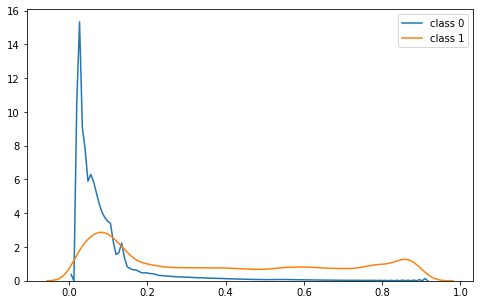

In [54]:
plt.figure(figsize=(8,5))
sns.kdeplot(y_result.y_score[y_result.default_90_12m == 0], label="class 0")
sns.kdeplot(y_result.y_score[y_result.default_90_12m == 1],label="class 1")

### Calibration Curve

In [55]:
# reliability diagram - UNCALIBRATE
fop, mpv = calibration_curve(Y_train_cv, y_prob[:,1], n_bins=10, normalize=True)

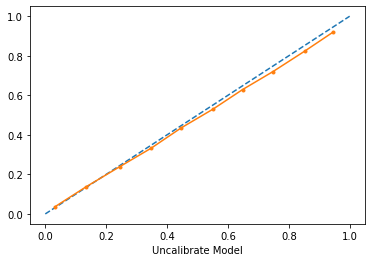

In [56]:
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.', label="uncalibrate")
pyplot.xlabel("Uncalibrate Model")
pyplot.show()

### Threshold (AUC) sin calibrar

In [57]:
from scipy import interpolate
from scipy.signal import savgol_filter
import heapq
fpr, tpr, thresh = metrics.roc_curve(Y_train_cv,y_result["y_score"])
tck_cost = interpolate.splrep(fpr, tpr, k=2, s=100)
spline_inter_cost = interpolate.splev(fpr, tck_cost, der=0)
first_der_cost = interpolate.splev(fpr, tck_cost, der=1)
second_der_cost = interpolate.splev(fpr, tck_cost, der=2)
curvature_cost = second_der_cost/(1+(first_der_cost)**2)**(3/2)

In [58]:
ind = heapq.nsmallest(10, range(len(savgol_filter(curvature_cost, 25, 3, deriv=0))), 
                     savgol_filter(curvature_cost, 25, 3,deriv=0).take)

Text(0.5, 1.0, 'Costo de la matriz de confusión vs Threshold \n tn = 0.25, fp=0.5,  fn=2.0, tp=0.75')

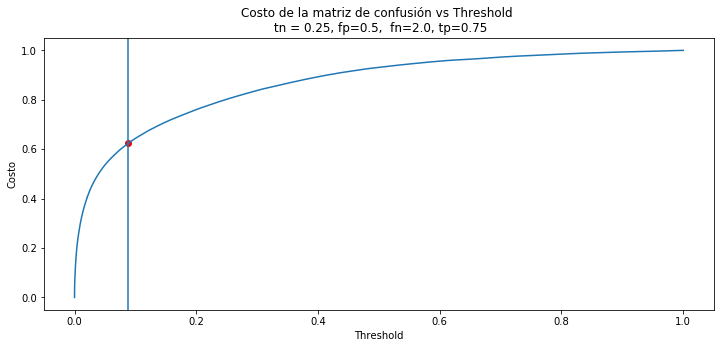

In [59]:
plt.figure(figsize=(12,5))
plt.plot(fpr, tpr)
plt.axvline(fpr[ind][-1])
plt.scatter(fpr[ind][-1], tpr[ind][-1], color="red")
plt.ylabel("Costo")
plt.xlabel("Threshold")
plt.title("Costo de la matriz de confusión vs Threshold \n tn = 0.25, fp=0.5,  fn=2.0, tp=0.75")

In [60]:
optimal_thresh_AUC_1 = thresh[ind][-1]

In [61]:
optimal_thresh_AUC_1

0.16870146922398482

In [62]:
from sklearn.metrics import *
print(f"accuracy_auc: {accuracy_score(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f"recall_auc: {recall_score(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f'Informedness: {balanced_accuracy_score(y_result["default_90_12m"], np.where(y_result["y_score"] >= optimal_thresh_AUC_1, 1, 0), adjusted=True)}')
print(f"confusion matrix: \n {confusion_matrix(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_AUC_1, 1,0))}")

accuracy_auc: 0.8807222772634833
recall_auc: 0.6236664593015455
Informedness: 0.5355332697764528
confusion matrix: 
 [[3085036  298173]
 [ 154261  255644]]


### Threshold PRC sin calibrar

In [63]:
def Find_Optimal_Cutoff_PRCAUC(target, predicted):
    """
        Optimal PR threshold based on F-Score max
    """
    pr, rc, threshold = precision_recall_curve(target, predicted)
    fscore = (2 * pr * rc) / (pr + rc)
    best_threshold = threshold[np.argmax(fscore)]
    return fscore, threshold, best_threshold

In [64]:
optimal_thresh_PRC = Find_Optimal_Cutoff_PRCAUC(y_result.default_90_12m, y_result.y_score)[-1]

In [65]:
optimal_thresh_PRC

0.27094350184316196

In [66]:
print(f"accuracy_prc: {accuracy_score(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_PRC, 1,0))}")
print(f"recall_prc: {recall_score(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_PRC, 1,0))}")
print(f'Informedness: {balanced_accuracy_score(y_result["default_90_12m"], np.where(y_result["y_score"] >= optimal_thresh_PRC, 1, 0), adjusted=True)}')
print(f"confusion matrix: \n {confusion_matrix(y_result.default_90_12m, np.where(y_result.y_score >= optimal_thresh_PRC, 1,0))}")

accuracy_prc: 0.9062833334299998
recall_prc: 0.5306888181407887
Informedness: 0.48247867209305717
confusion matrix: 
 [[3220104  163105]
 [ 192373  217532]]


In [67]:
y_result["y_label_PRC"] = y_result.y_score.apply(lambda x: 1 if x >= optimal_thresh_PRC else 0)
y_result["y_label_AUC"] = y_result.y_score.apply(lambda x: 1 if x >= optimal_thresh_AUC_1 else 0)
y_result["set_type"] = "train_cv"

In [68]:
y_result.head()

,default_90_12m,id,fecha,y_score,y_label_PRC,y_label_AUC,set_type
1,0,264349,2016-02-01,0.138626,0,0,train_cv
2,1,367623,2018-06-01,0.626401,1,1,train_cv
3,0,288289,2014-09-01,0.014214,0,0,train_cv
4,0,98569158,2018-04-01,0.054644,0,0,train_cv
6,0,443959,2016-07-01,0.014020,0,0,train_cv


### Calificación Muestra Fuera de Tiempo (201808-201902)

In [193]:
df_oot = pd.read_csv("base_reentrenamiento_2020_oot.csv",header = 0, sep = ';', low_memory=False)
df_oot["id"] = df_oot["id"].astype("str")

In [194]:
df_oot["id"] = df_oot["id"].astype("str")

In [195]:
#base de fuera de tiempo 
#df_oot = df[(df.fecha>=201808) & (df.fecha<=201902)]
y_oot = df_oot.default_90_12m

In [196]:
df_oot['premora_ok'] = np.where((df_oot.atm_fa_cont >= 1) & (df_oot.atm_fa_cont < 31),1,0)

In [197]:
oot_groups_gkf = df_oot.id
oot_groups_lpgo = df_oot.premora_ok
oot_groups_lpgo_fecha = df_oot.fecha
y_result_oot = y_oot.to_frame().copy()

In [198]:
df_oot.drop("premora_ok",axis=1, inplace=True)

In [199]:
x_oot_cols = X_train_cv_final.columns.tolist()#["id"]+X_train_cv_final.columns.tolist()

In [200]:
X_oot = df_oot[x_oot_cols]

In [201]:
X_oot_final = X_oot.copy()

In [210]:
oot_cv = GroupKFold(n_splits=2)
y_prob_oot = cross_val_predict(best_model,
                              X=X_oot_final,
                              y=y_oot,
                              cv=oot_cv,
                              groups=oot_groups_gkf,
                              n_jobs=1,
                              method='predict_proba')


C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\eduperez\AppData\Local\Temp\joblib_memmaping_pool_44976_1841309347120
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


In [211]:
y_result_oot["y_score"] = y_prob_oot[:,1]

In [212]:
y_prob_oot

array([[0.91951921, 0.08048079],
       [0.94017978, 0.05982022],
       [0.94971201, 0.05028799],
       ...,
       [0.98760661, 0.01239339],
       [0.98061308, 0.01938692],
       [0.92818743, 0.07181257]])

In [213]:
y_oot_label = np.where(y_result_oot.y_score >= optimal_thresh_AUC_1, 1,0)

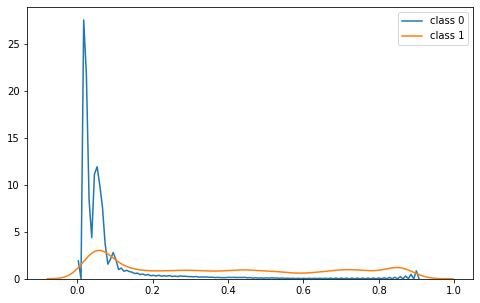

In [82]:
plt.figure(figsize=(8,5))
sns.kdeplot(y_result_oot.y_score[y_result_oot.default_90_12m == 0], label="class 0")
sns.kdeplot(y_result_oot.y_score[y_result_oot.default_90_12m == 1],label="class 1")

### Threshold AUC

In [83]:
from sklearn.metrics import *
print(f"accuracy_auc: {accuracy_score(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f"recall_auc: {recall_score(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f'Informedness: {balanced_accuracy_score(y_result_oot["default_90_12m"], np.where(y_result_oot["y_score"] >= optimal_thresh_AUC_1, 1, 0), adjusted=True)}')
print(f"confusion matrix: \n {confusion_matrix(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_AUC_1, 1,0))}")

accuracy_auc: 0.8870800219398056
recall_auc: 0.6411539280391739
Informedness: 0.5559226772463983
confusion matrix: 
 [[915893  85336]
 [ 40452  72276]]


In [84]:
print(f"accuracy_auc: {accuracy_score(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_PRC, 1,0))}") 
print(f"recall_auc: {recall_score(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_PRC, 1,0))}")
print(f'Informedness: {balanced_accuracy_score(y_result_oot["default_90_12m"], np.where(y_result_oot["y_score"] >= optimal_thresh_PRC, 1, 0), adjusted=True)}')
print(f"confusion matrix: \n {confusion_matrix(y_result_oot.default_90_12m, np.where(y_result_oot.y_score >= optimal_thresh_PRC, 1,0))}")

accuracy_auc: 0.9095719134580599
recall_auc: 0.5561617344404229
Informedness: 0.5055239682550647
confusion matrix: 
 [[950529  50700]
 [ 50033  62695]]


# Calificacion del Validation set

In [85]:
y_result_valid = df_validation[["id", "fecha", "default_90_12m"]].copy()

In [86]:
y_result.fecha.unique()

array(['2016-02-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2014-08-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2017-07-01T00:00:00.000000000',
       '2015-02-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2015-12-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2015-08-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2017-06-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-07-01

In [87]:
y_result_valid.fecha.unique()

array(['2016-12-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2015-11-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2015-08-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2015-07-01

In [88]:
y_prob_valid = cross_val_predict(best_model, 
                                 X = X_validation_final, 
                                 y = Y_validation, 
                                 cv=outer_cv, 
                                 groups = outer_cv_groups, 
                                 n_jobs=-1, 
                                 method='predict_proba')

In [89]:
y_result_valid["y_score"] = y_prob_valid[:,1]
y_result_valid["set_type"] = "valid"

In [91]:
y_result_valid["y_label_PRC"] = np.where(y_result_valid.y_score >= optimal_thresh_PRC, 1,0)
y_result_valid["y_label_AUC"] = np.where(y_result_valid.y_score >= optimal_thresh_AUC_1, 1,0)

In [92]:
print(f"accuracy_PRC: {accuracy_score(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_PRC, 1,0))}")
print(f"recall_PRC: {recall_score(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_PRC, 1,0))}")
print(f'Informedness_PRC: {balanced_accuracy_score(y_result_valid["default_90_12m"], np.where(y_result_valid["y_score"] >= optimal_thresh_PRC, 1, 0), adjusted=True)}')
print(f"confusion matrix PRC: \n {confusion_matrix(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_PRC, 1,0))}")

accuracy_PRC: 0.937108924902009
recall_PRC: 0.4082053632821453
Informedness_PRC: 0.38203128666750263
confusion matrix PRC: 
 [[550831  14805]
 [ 23238  16029]]


In [93]:
print(f"accuracy_AUC: {accuracy_score(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f"recall_AUC: {recall_score(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_AUC_1, 1,0))}")
print(f'Informedness_AUC: {balanced_accuracy_score(y_result_valid["default_90_12m"], np.where(y_result_valid["y_score"] >= optimal_thresh_AUC_1, 1, 0), adjusted=True)}')
print(f"confusion matrix AUC: \n {confusion_matrix(y_result_valid.default_90_12m, np.where(y_result_valid.y_score >= optimal_thresh_AUC_1, 1,0))}")

accuracy_AUC: 0.9178876613275186
recall_AUC: 0.5285608780910179
Informedness_AUC: 0.473475982504457
confusion matrix AUC: 
 [[534478  31158]
 [ 18512  20755]]


### FEATURE IMPORTANCE BY PERMUTATION IMPORTANCE OOT SET

# RESULT VALIDATION AND TRAIN

In [227]:
result_oot = pd.concat([df_oot[["id","fecha","atm_fa_cont"]], y_result_oot], axis=1)

In [232]:
result_oot.columns

Index(['id', 'fecha', 'atm_fa_cont', 'default_90_12m', 'y_score'], dtype='object')

In [233]:
result_validation = y_result_valid[['id', 'fecha', 'default_90_12m', 'y_score']]
result_validation["atm_fa_cont"] = df_validation[["atm_fa_cont"]]
result_validation.head()

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,fecha,default_90_12m,y_score,atm_fa_cont
9,98750291,2016-12-01,0,0.036886,0
14,74009101,2016-05-01,0,0.052779,0
18,98547136,2018-05-01,0,0.030297,0
33,48228381,2018-01-01,0,0.018779,0
51,342013,2015-04-01,0,0.007069,0


In [234]:
result_oot.head()

,id,fecha,atm_fa_cont,default_90_12m,y_score
0,98850902,2018-08-01,0,0,0.080481
1,98748475,2018-09-01,0,0,0.059820
2,71053839,2018-12-01,0,0,0.050288
3,98834903,2019-01-01,0,0,0.042672
4,60621539,2018-09-01,0,0,0.017201


In [236]:
result_train_cv = y_result[['id', 'fecha', 'default_90_12m', 'y_score']]
result_train_cv["atm_fa_cont"] = df_train_cv[["atm_fa_cont"]]
result_train_cv.head()

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,fecha,default_90_12m,y_score,atm_fa_cont
1,264349,2016-02-01,0,0.138626,0
2,367623,2018-06-01,1,0.626401,53
3,288289,2014-09-01,0,0.014214,0
4,98569158,2018-04-01,0,0.054644,0
6,443959,2016-07-01,0,0.014020,0


# result out of time (oot)

In [ ]:
df_oot["fecha"] = pd.to_datetime(df_oot['fecha'].apply(lambda x: str(x)[:4]+"-"+str(x)[-2:]), format='%Y-%m')

In [238]:
result_oot = pd.concat([df_oot[["id","fecha","atm_fa_cont"]], y_result_oot], axis=1)

In [239]:
result_oot["y_label_AUC"] = np.where(y_result_oot.y_score >= optimal_thresh_AUC_1, 1,0)
result_oot["y_label_PRC"] = np.where(y_result_oot.y_score >= optimal_thresh_PRC, 1,0)
result_oot["set_type"] = "oot"

In [240]:
auc_x_mes_oot = result_oot.groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))
auc_x_mes_train = result_train_cv.groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))
auc_x_mes_valid = result_validation.groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))

In [241]:
oot_dates = result_oot.fecha.unique()
oot_dates.sort()
print(oot_dates)

['2018-08-01T00:00:00.000000000' '2018-09-01T00:00:00.000000000'
 '2018-10-01T00:00:00.000000000' '2018-11-01T00:00:00.000000000'
 '2018-12-01T00:00:00.000000000' '2019-01-01T00:00:00.000000000'
 '2019-02-01T00:00:00.000000000' '2019-03-01T00:00:00.000000000'
 '2019-04-01T00:00:00.000000000' '2019-05-01T00:00:00.000000000'
 '2019-06-01T00:00:00.000000000' '2019-07-01T00:00:00.000000000']


In [242]:
train_dates = result_train_cv.fecha.unique()
train_dates.sort()
print(train_dates)

['2014-07-01T00:00:00.000000000' '2014-08-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2016-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2016-12-01T00:00:00.000000000'
 '2017-01-01T00:00:00.000

In [243]:
validation_dates = result_validation.fecha.unique()
validation_dates.sort()
print(validation_dates)

['2014-07-01T00:00:00.000000000' '2014-08-01T00:00:00.000000000'
 '2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2016-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2016-12-01T00:00:00.000000000'
 '2017-01-01T00:00:00.000

In [244]:
auc_x_mess = pd.concat([auc_x_mes_oot, auc_x_mes_train, auc_x_mes_valid]).to_frame().reset_index()
auc_x_mess.set_index("fecha", inplace=True)

In [245]:
auc_x_mes_train

fecha
2014-07-01    0.861310
2014-08-01    0.859277
2014-09-01    0.866209
2014-10-01    0.873051
2014-11-01    0.869631
2014-12-01    0.860960
2015-01-01    0.851481
2015-02-01    0.851981
2015-03-01    0.866865
2015-04-01    0.859862
2015-05-01    0.853410
2015-06-01    0.851062
2015-07-01    0.848709
2015-08-01    0.847070
2015-09-01    0.849615
2015-10-01    0.853369
2015-11-01    0.857550
2015-12-01    0.852304
2016-01-01    0.854484
2016-02-01    0.865872
2016-03-01    0.875583
2016-04-01    0.878278
2016-05-01    0.876716
2016-06-01    0.879072
2016-07-01    0.876671
2016-08-01    0.874466
2016-09-01    0.877079
2016-10-01    0.878570
2016-11-01    0.873186
2016-12-01    0.868972
2017-01-01    0.866755
2017-02-01    0.867898
2017-03-01    0.877414
2017-04-01    0.876667
2017-05-01    0.877482
2017-06-01    0.874381
2017-07-01    0.871630
2017-08-01    0.866303
2017-09-01    0.869989
2017-10-01    0.866878
2017-11-01    0.864272
2017-12-01    0.853546
2018-01-01    0.855135
2018-

In [246]:
auc_x_mes_valid

fecha
2014-07-01    0.843601
2014-08-01    0.848518
2014-09-01    0.858201
2014-10-01    0.860965
2014-11-01    0.854178
2014-12-01    0.855474
2015-01-01    0.846194
2015-02-01    0.842646
2015-03-01    0.862913
2015-04-01    0.855333
2015-05-01    0.856886
2015-06-01    0.858001
2015-07-01    0.848306
2015-08-01    0.841085
2015-09-01    0.836692
2015-10-01    0.841632
2015-11-01    0.848410
2015-12-01    0.846523
2016-01-01    0.841086
2016-02-01    0.847190
2016-03-01    0.857377
2016-04-01    0.862269
2016-05-01    0.857420
2016-06-01    0.857941
2016-07-01    0.855632
2016-08-01    0.854889
2016-09-01    0.852950
2016-10-01    0.854674
2016-11-01    0.856417
2016-12-01    0.848989
2017-01-01    0.853249
2017-02-01    0.851459
2017-03-01    0.863163
2017-04-01    0.862098
2017-05-01    0.863263
2017-06-01    0.857109
2017-07-01    0.858945
2017-08-01    0.860837
2017-09-01    0.862203
2017-10-01    0.857111
2017-11-01    0.860351
2017-12-01    0.853782
2018-01-01    0.859640
2018-

In [247]:
auc_x_mes_oot

fecha
2018-08-01    0.871480
2018-09-01    0.871814
2018-10-01    0.866802
2018-11-01    0.863788
2018-12-01    0.854184
2019-01-01    0.854037
2019-02-01    0.859365
2019-03-01    0.860857
2019-04-01    0.863395
2019-05-01    0.868838
2019-06-01    0.869269
2019-07-01    0.874876
dtype: float64

In [248]:
auc_x_mes_all = pd.concat([result_train_cv,result_validation, result_oot.drop(['set_type', 'y_label_AUC', 'y_label_PRC'],axis=1)], axis=0).groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


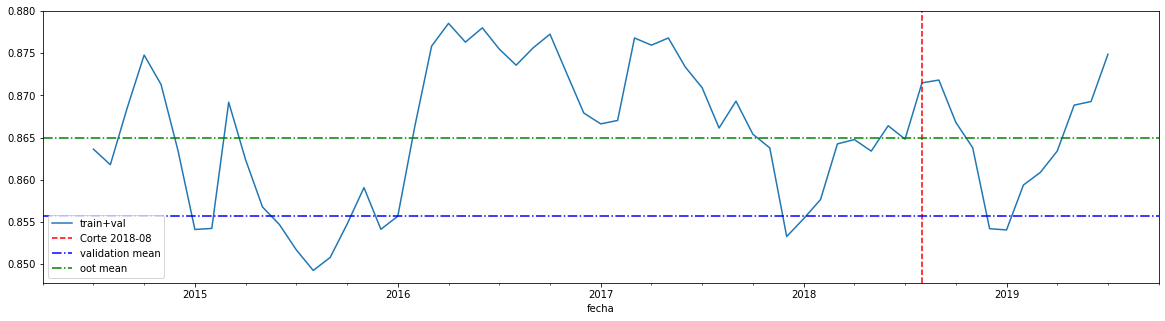

In [249]:
auc_x_mes_all.plot(figsize=(20,5), label="train+val")
plt.axvline("2018-08-01", linestyle="--", color="red", label="Corte 2018-08")
plt.axhline(auc_x_mes_valid.mean(), linestyle="-.", color="blue", label="validation mean")
plt.axhline(auc_x_mes_oot.mean(), linestyle="-.", color="green", label="oot mean")

#auc_x_mes_oot.plot(figsize=(20,5), label="oot")
#auc_x_mes_train.plot(figsize=(20,5), label="train_cv")
#auc_x_mes_valid.plot(figsize=(20,5), label="validation")
#plt.axhline(auc_x_mes_train.mean(), linestyle="-.", label="mean")
#plt.axhline(auc_x_mes_train.mean(), linestyle="-.", label="mean", color="blue")
#plt.axhline(auc_x_mes_oot.mean(), linestyle="-.", label="mean", color="red")

#plt.axhline(auc_x_mes_train.mean() + 2*auc_x_mes_train.std(), linestyle="--", label="+ 2 x std")
#plt.axhline(auc_x_mes_train.mean() - 2*auc_x_mes_train.std(), linestyle="--", label="- 2 x std", color="red")
#plt.tight_layout()
plt.legend()

In [250]:
auc_ts = result_oot.groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))
auc_ts

fecha
2018-08-01    0.871480
2018-09-01    0.871814
2018-10-01    0.866802
2018-11-01    0.863788
2018-12-01    0.854184
2019-01-01    0.854037
2019-02-01    0.859365
2019-03-01    0.860857
2019-04-01    0.863395
2019-05-01    0.868838
2019-06-01    0.869269
2019-07-01    0.874876
dtype: float64

In [251]:
result_oot.groupby("fecha").apply(lambda x: recall_score(x["default_90_12m"],x["y_label_AUC"]))

fecha
2018-08-01    0.655142
2018-09-01    0.658401
2018-10-01    0.656651
2018-11-01    0.646239
2018-12-01    0.591064
2019-01-01    0.573210
2019-02-01    0.611946
2019-03-01    0.624209
2019-04-01    0.651228
2019-05-01    0.674482
2019-06-01    0.674941
2019-07-01    0.684828
dtype: float64

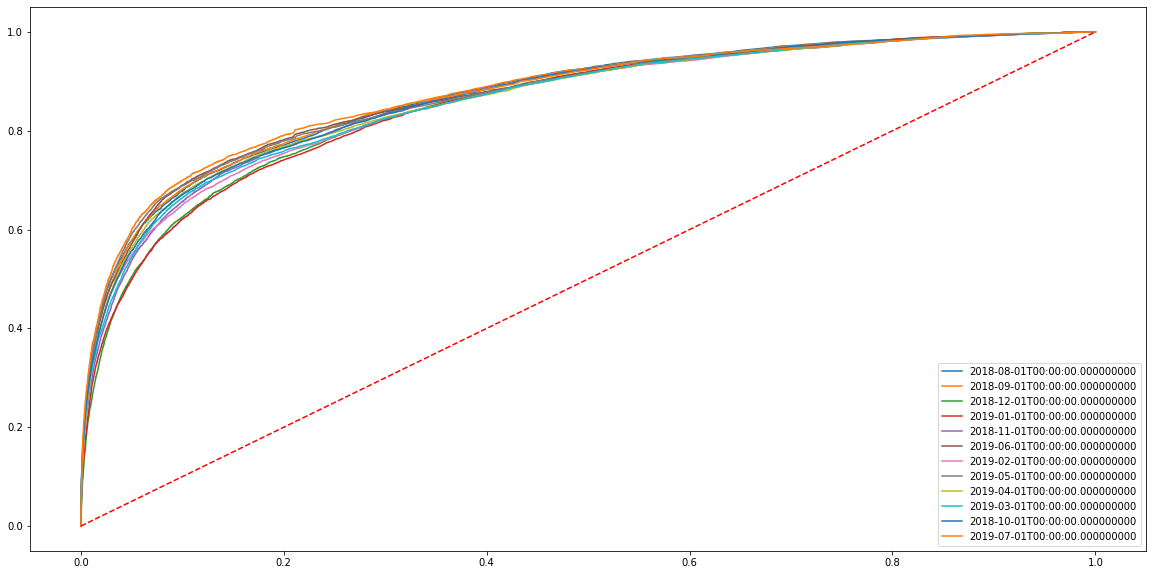

In [252]:
plt.figure(figsize=(20,10))

for f in result_oot.fecha.unique():
    fpr, tpr, _ = roc_curve(result_oot[result_oot.fecha == f].default_90_12m, result_oot[result_oot.fecha == f].y_score)
    plt.plot(fpr, tpr, label=str(f))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.legend()

In [253]:
from scipy.optimize import curve_fit
def linear(x, a, b):
    return a*x + b
fit_params, _ = curve_fit(linear, np.arange(auc_ts.shape[0]), auc_ts.values)

In [254]:
decay = list()
max_range = 25
for i in range(0,max_range):
    decay.append(linear(i, *fit_params))

In [255]:
auc_ts_df = pd.DataFrame(auc_ts.values, columns=["auc predicted"])
auc_ts_df["date"] = pd.date_range("2018-08-01",periods= len(auc_ts_df), freq="1M")
auc_ts_df.set_index("date", inplace=True)

In [256]:
auc_decay = pd.DataFrame(decay, columns=["auc fit decay"])
auc_decay["date"] = pd.date_range("2018-08-01", periods=max_range, freq="1M")
auc_decay.set_index("date", inplace=True)

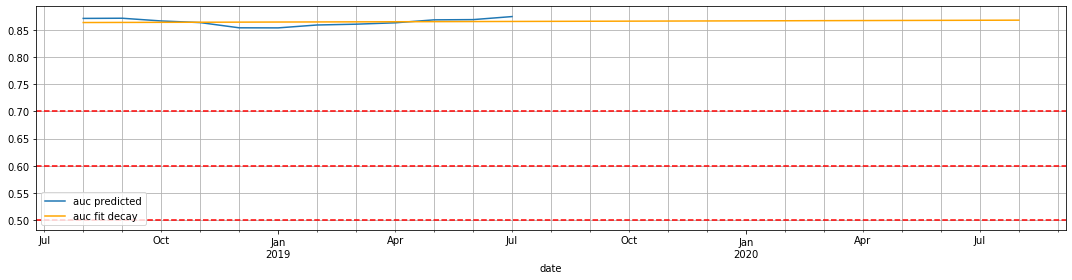

In [257]:
import matplotlib.dates as dates

ax = auc_ts_df.plot(figsize=(15,4))
auc_decay.plot(ax = ax, color="orange")
plt.axhline(0.7, color = "red", linestyle="--");
plt.axhline(0.6, color = "red", linestyle="--");
plt.axhline(0.5, color = "red", linestyle="--");
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
plt.tight_layout()

In [258]:
perc_population_real = result_oot.groupby("fecha").default_90_12m.agg(["sum", "count"])
perc_population_real["percent_default"] = (100* perc_population_real["sum"]/perc_population_real["count"])

In [259]:
perc_population_pred = result_oot.groupby("fecha").y_label_AUC.agg(["sum", "count"])
perc_population_pred["percent_default"] = (100* perc_population_pred["sum"]/perc_population_pred["count"])

In [260]:
population_result = perc_population_real.join(perc_population_pred, lsuffix="_real", rsuffix ="_pred")

In [261]:
population_result["total_difference"] = population_result["percent_default_pred"]-population_result["percent_default_real"]

In [262]:
auc_x_mes_all = pd.concat([result_train_cv,result_validation, result_oot], axis=0).groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [263]:
population_result

,sum_real,count_real,percent_default_real,sum_pred,count_pred,percent_default_pred,total_difference
fecha,,,,,,,
2018-08-01,10065,90732,11.093109,13491,90732,14.869065,3.775956
2018-09-01,9880,90519,10.914836,13313,90519,14.707409,3.792574
2018-10-01,9352,90422,10.342616,13528,90422,14.960961,4.618345
2018-11-01,9187,90575,10.142975,13612,90575,15.028429,4.885454
2018-12-01,9109,91301,9.976890,12129,91301,13.284630,3.307740
2019-01-01,9541,92032,10.367046,11626,92032,12.632563,2.265516
2019-02-01,9710,92877,10.454687,12443,92877,13.397289,2.942602
2019-03-01,10112,94970,10.647573,12972,94970,13.659050,3.011477
2019-04-01,9608,95497,10.061049,13775,95497,14.424537,4.363488


In [264]:
print("difference sin atmfa = {} +/- {}".format(population_result.total_difference.mean(), population_result.total_difference.std()))

difference sin atmfa = 4.024351354411504 +/- 0.9928445738481195


# Premora_ok = 1 only

In [265]:
df_premora_ok_1_oot = df_oot.copy()
df_premora_ok_1_oot["premora_ok"] = np.where((df_premora_ok_1_oot.atm_fa_cont >= 1) & (df_premora_ok_1_oot.atm_fa_cont < 31),1,0)

In [266]:
index_premora_ok_1 = df_premora_ok_1_oot[df_premora_ok_1_oot["premora_ok"] == 1 ].index

In [267]:
result_oot.iloc[index_premora_ok_1].head()

,id,fecha,atm_fa_cont,default_90_12m,y_score,y_label_AUC,y_label_PRC,set_type
6,98598201,2018-11-01,25,0,0.172137,1,0,oot
18,98830773,2019-02-01,1,0,0.126939,0,0,oot
38,74065814,2018-11-01,26,0,0.253950,1,0,oot
63,48072599,2019-04-01,15,0,0.456635,1,1,oot
85,98866068,2019-04-01,25,0,0.442780,1,1,oot


In [268]:
auc_oot_preok1 = result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))
accuracy_oot_preok1 = result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: accuracy_score(x["default_90_12m"],x["y_label_AUC"]))
recall_oot_preok1 = result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: recall_score(x["default_90_12m"],x["y_label_AUC"]))
informedness_oot_preok1 = result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: balanced_accuracy_score(x["default_90_12m"],x["y_label_AUC"], adjusted=True))
conf_mat_oot_preok1 = result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: confusion_matrix(x["default_90_12m"], x["y_label_AUC"]).flatten())
conf_mat_oot_preok1 = pd.DataFrame(np.column_stack(list(zip(*conf_mat_oot_preok1))), columns=['TN','FP','FN','TP'], index=conf_mat_oot_preok1.index)

In [269]:
result_oot.iloc[index_premora_ok_1].groupby("fecha").apply(lambda x: average_precision_score(x["default_90_12m"],x["y_score"]))

fecha
2018-08-01    0.614022
2018-09-01    0.563568
2018-10-01    0.490383
2018-11-01    0.516453
2018-12-01    0.565040
2019-01-01    0.677125
2019-02-01    0.658482
2019-03-01    0.583764
2019-04-01    0.595891
2019-05-01    0.604712
2019-06-01    0.567076
2019-07-01    0.557584
dtype: float64

In [270]:
conf_mat_oot_preok1

,TN,FP,FN,TP
fecha,,,,
2018-08-01,1499,3176,142,2253
2018-09-01,866,3127,80,2065
2018-10-01,1512,3490,99,1847
2018-11-01,1632,3510,141,1857
2018-12-01,681,1638,86,1217
2019-01-01,986,2233,100,2059
2019-02-01,973,3126,106,2513
2019-03-01,733,2932,75,1977
2019-04-01,1032,3635,106,2562


In [271]:
df_premora_ok_1_valid = df_validation.copy()
df_premora_ok_1_valid.reset_index(inplace=True, drop=True)
df_premora_ok_1_valid["premora_ok"] = np.where((df_premora_ok_1_valid.atm_fa_cont >= 1) & (df_premora_ok_1_valid.atm_fa_cont < 31),1,0)
index_valid_premora_ok_1 = df_premora_ok_1_valid[df_premora_ok_1_valid["premora_ok"] == 1 ].index

y_result_valid_preok1 = y_result_valid.copy()
y_result_valid_preok1.reset_index(inplace=True, drop=True)
y_result_valid_preok1 = y_result_valid_preok1.iloc[index_valid_premora_ok_1]

auc_valid_preok1 = y_result_valid_preok1.groupby("fecha").apply(lambda x: roc_auc_score(x["default_90_12m"],x["y_score"]))
accuracy_valid_preok1 = y_result_valid_preok1.groupby("fecha").apply(lambda x: accuracy_score(x["default_90_12m"],x["y_label_AUC"]))
recall_valid_preok1 = y_result_valid_preok1.groupby("fecha").apply(lambda x: recall_score(x["default_90_12m"],x["y_label_AUC"]))
informedness_valid_preok1 = y_result_valid_preok1.groupby("fecha").apply(lambda x: balanced_accuracy_score(x["default_90_12m"],x["y_label_AUC"], adjusted=True))
conf_mat_valid_preok1 = y_result_valid_preok1.groupby("fecha").apply(lambda x: confusion_matrix(x["default_90_12m"], x["y_label_AUC"]).flatten())
conf_mat_valid_preok1 = pd.DataFrame(np.column_stack(list(zip(*conf_mat_valid_preok1))), columns=['TN','FP','FN','TP'], index=conf_mat_valid_preok1.index)

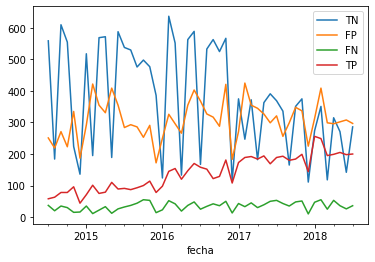

In [272]:
conf_mat_valid_preok1.plot()

# qcuts octiles

In [273]:
df_qcut_valid = result_validation.copy()

In [274]:
df_qcut_valid["y_group"], qbins_valid = pd.qcut(result_validation.y_score, 
                                   8,
                                   retbins=True,
                                   labels=range(8))

In [275]:
df_qcut_valid.groupby("y_group")["y_score"].mean()

y_group
0    0.007564
1    0.011542
2    0.015793
3    0.022879
4    0.034276
5    0.050781
6    0.076367
7    0.303599
Name: y_score, dtype: float64

In [276]:
qbins_valid

array([0.00589338, 0.00858105, 0.01329079, 0.01852023, 0.0280169 ,
       0.0412039 , 0.05959549, 0.10889708, 0.90048087])

In [277]:
df_qcut_train = result_train_cv.copy()

In [278]:
df_qcut_train["y_group"], qbins_train = pd.qcut(result_train_cv.y_score, 
                                   8,
                                   retbins=True,
                                   labels=range(8))

In [279]:
qbins_train

array([0.01272006, 0.01674992, 0.0223779 , 0.03153619, 0.04909369,
       0.07159149, 0.10391012, 0.2056138 , 0.91132319])

# Final Result

In [280]:
result_oot.head()

,id,fecha,atm_fa_cont,default_90_12m,y_score,y_label_AUC,y_label_PRC,set_type
0,98850902,2018-08-01,0,0,0.080481,0,0,oot
1,98748475,2018-09-01,0,0,0.059820,0,0,oot
2,71053839,2018-12-01,0,0,0.050288,0,0,oot
3,98834903,2019-01-01,0,0,0.042672,0,0,oot
4,60621539,2018-09-01,0,0,0.017201,0,0,oot


In [281]:
result_validation["y_label_AUC"] = np.where(result_validation["y_score"] >= optimal_thresh_AUC_1,1,0)
result_validation["y_label_PRC"] = np.where(result_validation["y_score"] >= optimal_thresh_PRC,1,0)
result_validation["set_type"] = "valid"

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [282]:
result_train_cv["y_label_AUC"] = np.where(result_train_cv["y_score"] >= optimal_thresh_AUC_1,1,0)
result_train_cv["y_label_PRC"] = np.where(result_train_cv["y_score"] >= optimal_thresh_PRC,1,0)
result_train_cv["set_type"] = "train"

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [283]:
final_result = pd.concat([result_train_cv,result_validation,result_oot], axis=0)

C:\Users\eduperez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [290]:
final_result.isna().any()

atm_fa_cont       False
default_90_12m    False
fecha             False
id                False
set_type          False
y_label_AUC       False
y_label_PRC       False
y_score           False
dtype: bool

In [288]:
final_result.head()

,atm_fa_cont,default_90_12m,fecha,id,set_type,y_label_AUC,y_label_PRC,y_score
1,0,0,2016-02-01,264349,train,0,0,0.138626
2,53,1,2018-06-01,367623,train,1,1,0.626401
3,0,0,2014-09-01,288289,train,0,0,0.014214
4,0,0,2018-04-01,98569158,train,0,0,0.054644
6,0,0,2016-07-01,443959,train,0,0,0.014020


In [289]:
final_result[['id','fecha','default_90_12m','atm_fa_cont','y_score','y_label_AUC','set_type']].to_csv(TAG+"_final_result.csv")

# Sensitivity Analysis

# Single Client Sensitivity

In [161]:
sensitivity_df = df_oot[["id","fecha","default_90_12m"]+x_oot_cols].copy()
client_sample = np.random.choice(sensitivity_df["id"].unique(),1).tolist()
sample_df = sensitivity_df[sensitivity_df.id.isin(client_sample)]
sensitivity_df.repr_rodamientos_12m = sensitivity_df.repr_rodamientos_12m.astype("int64")
sensitivity_df.repr_ddir_cliente_12m = sensitivity_df.repr_ddir_cliente_12m.astype("int64")
sensitivity_df.repr_mora_sup_61_12m = sensitivity_df.repr_mora_sup_61_12m.astype("int64")

In [162]:
def plot_variations_one(df, cols, thresh):
    a = df[df.type =="fake"].groupby(["var_name", "value","type"])["prediction"].mean().reset_index()
    b = df[df.type =="real"].groupby(["var_name", "value","type"])["prediction"].mean().reset_index()
    for col in cols:
        print(col)
        a[(a.var_name == col) & ( a.type =="fake")][["value", "prediction"]].plot.scatter("value", "prediction", figsize=(20,5))
        
        plt.scatter(b[b.var_name == col]["value"],
                    b[b.var_name == col]["prediction"], marker="*", color="red", s=80)
        
        plt.title(col)
        plt.axhline(thresh, color="green", label="threshold")
        plt.legend()
        plt.show()

In [163]:
unique_cat_vals = list()
cat_cols = sensitivity_df[x_oot_cols].select_dtypes("int64").columns
cont_cols = sensitivity_df[x_oot_cols].select_dtypes(float).columns

for i in cat_cols:
    unique_cat_vals.append(sensitivity_df[x_oot_cols][i].unique())
    
unique_cont_vals = list()
for i in cont_cols:
    if df[i].min() == -999.0:
        unique_cont_vals.append((i, 0, sensitivity_df[x_oot_cols][i].max()))
    else:
        unique_cont_vals.append((i, sensitivity_df[x_oot_cols][i].min(), sensitivity_df[x_oot_cols][i].max()))

In [164]:
single_record = sensitivity_df[x_oot_cols][sensitivity_df.default_90_12m == 1].sample(1)

In [165]:
perturbed_predictions_cat = list()
pred_row_single_cat = single_record[x_oot_cols].copy()
for col_cat, vals in zip(cat_cols, unique_cat_vals):
    perturbed_predictions_cat.append((col_cat, single_record[col_cat].values[0], "real", best_model.predict_proba(pred_row_single_cat)[:,1][0]))
    for val_cat in vals:
        pred_row_single_cat[col_cat] = val_cat
        perturbed_predictions_cat.append((col_cat, val_cat, "fake", best_model.predict_proba(pred_row_single_cat)[:,1][0]))
        pred_row_single_cat[col_cat] = single_record[col_cat].values[0]
        
result_perturbation_cat = pd.DataFrame(perturbed_predictions_cat, columns=["var_name", "value","type", "prediction"])

In [168]:
perturbed_predictions_cont = list()
pred_row_single_cont = single_record[x_oot_cols].copy()     
for col_cont, minval, maxval in unique_cont_vals:
    perturbed_predictions_cont.append((col_cont, single_record[col_cont].values[0], "real", best_model.predict_proba(pred_row_single_cont)[:,1][0]))
    vals = np.linspace(minval, maxval, 100)
    for val_cont in vals:
        pred_row_single_cont[col_cont] = val_cont
        perturbed_predictions_cont.append((col_cont, val_cont, "fake", best_model.predict_proba(pred_row_single_cont)[:,1][0]))
        pred_row_single_cont[col_cont] = single_record[col_cont].values[0]
result_perturbation_cont = pd.DataFrame(perturbed_predictions_cont, columns=["var_name", "value", "type","prediction"]) 

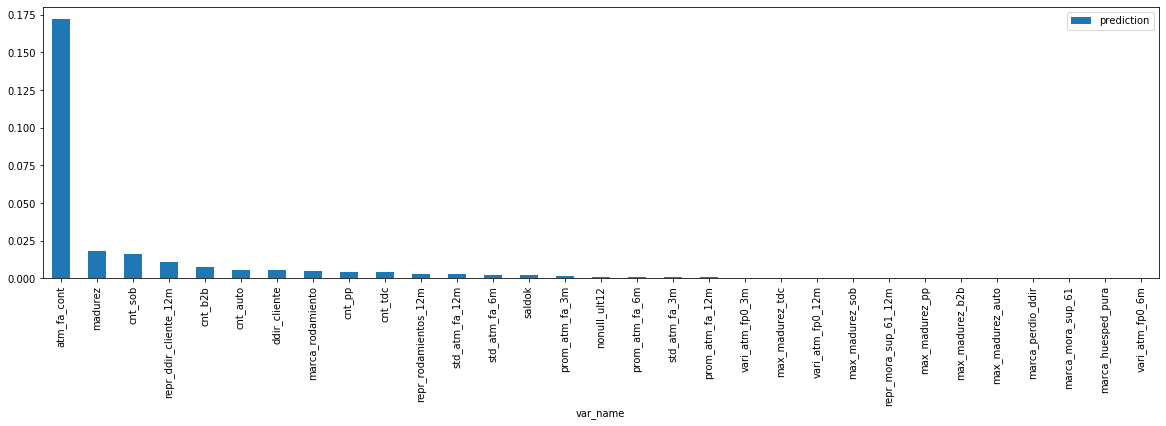

In [169]:
single_result = pd.concat([result_perturbation_cat[result_perturbation_cat["type"]=="fake"].groupby("var_name").std()[["prediction"]],
           result_perturbation_cont[result_perturbation_cont["type"]=="fake"].groupby("var_name").std()[["prediction"]]], 
          axis=0 ).sort_values(by="prediction", ascending=False)
single_result.plot(kind="bar", figsize=(20,5))

saldok


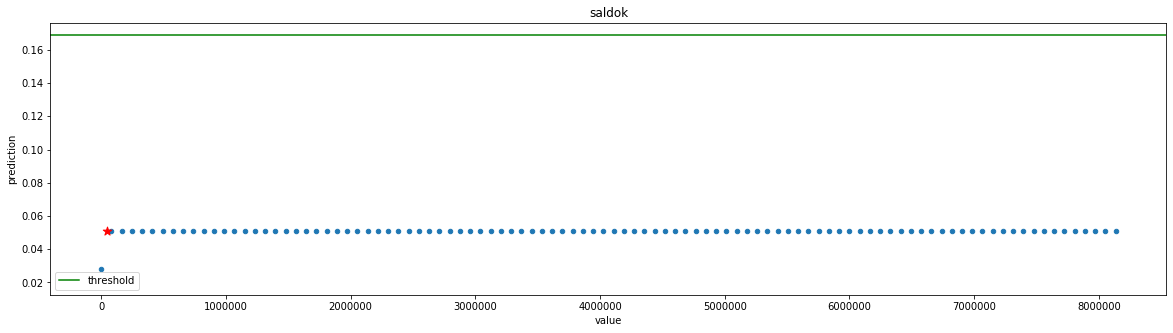

std_atm_fa_6m


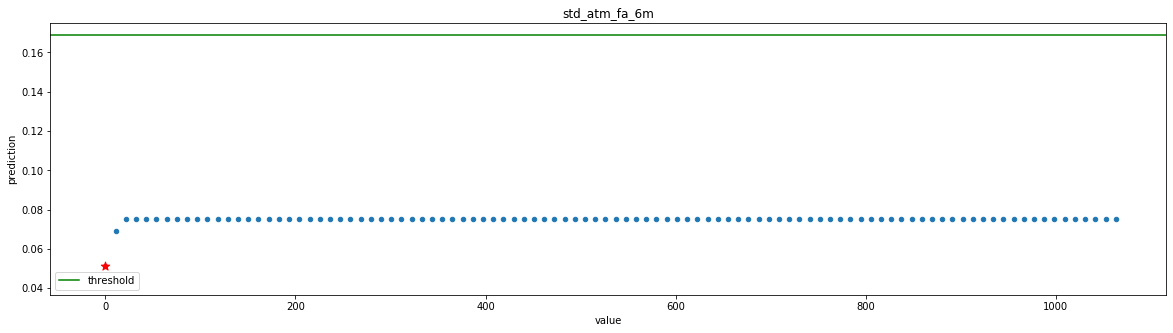

prom_atm_fa_3m


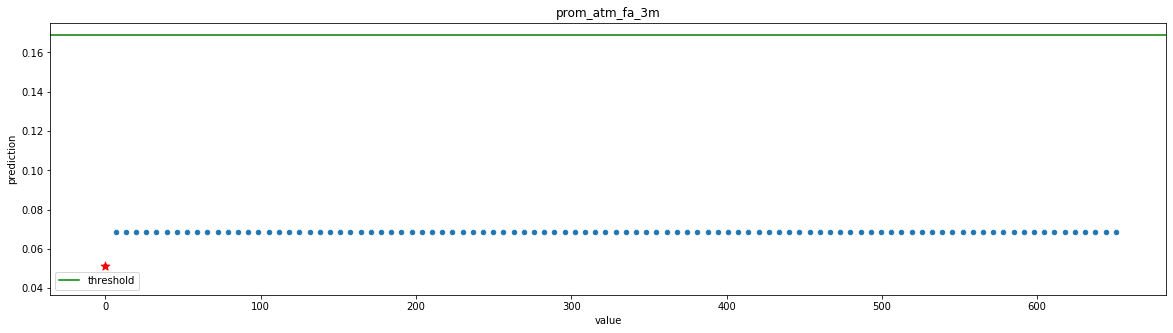

std_atm_fa_12m


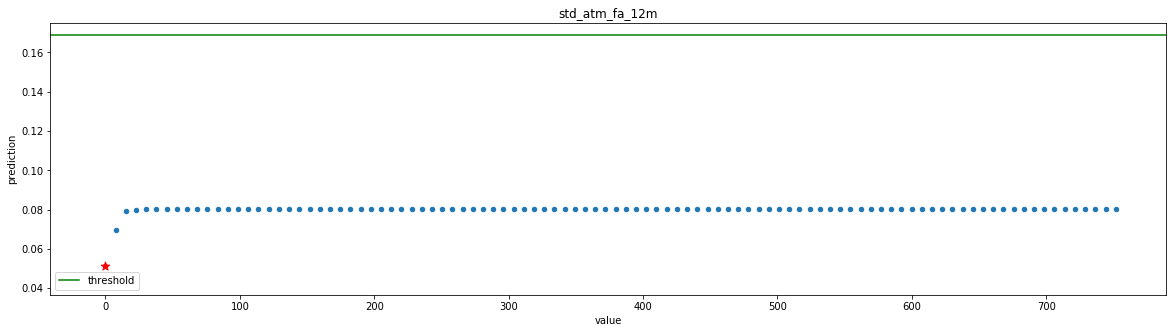

prom_atm_fa_12m


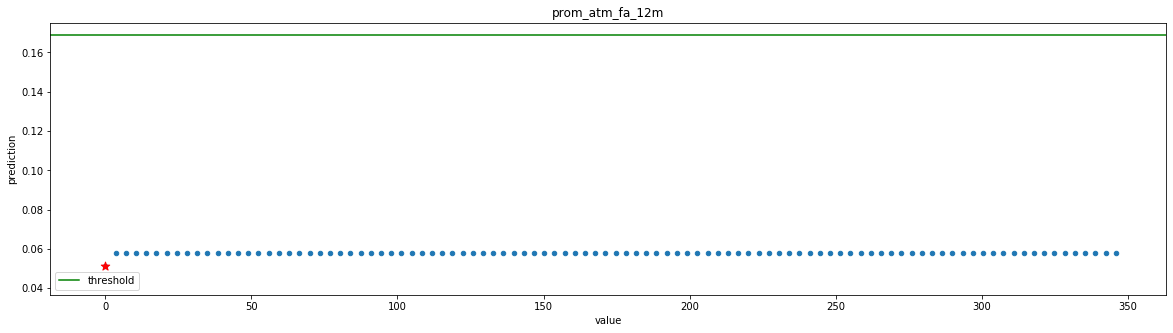

vari_atm_fp0_12m


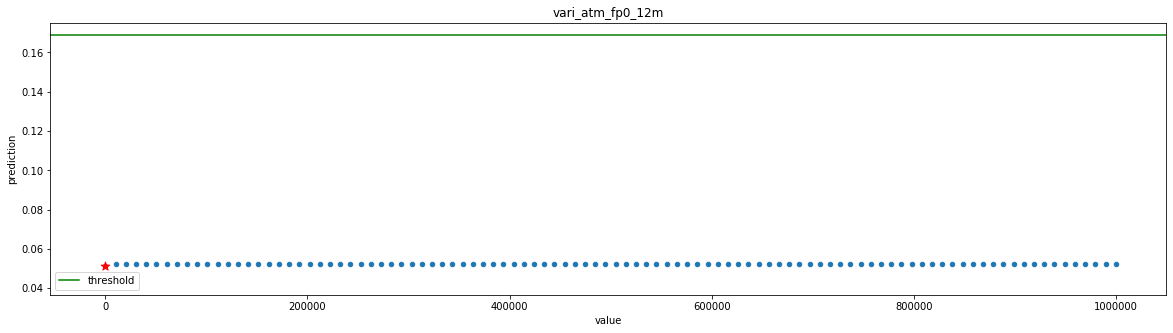

vari_atm_fp0_6m


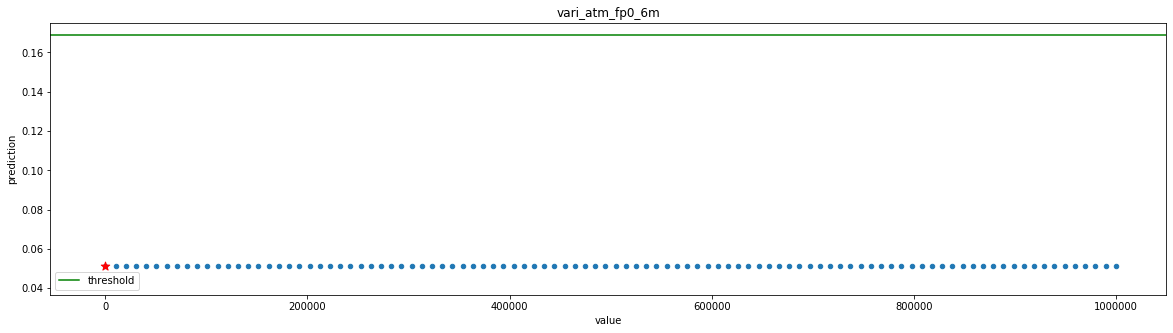

prom_atm_fa_6m


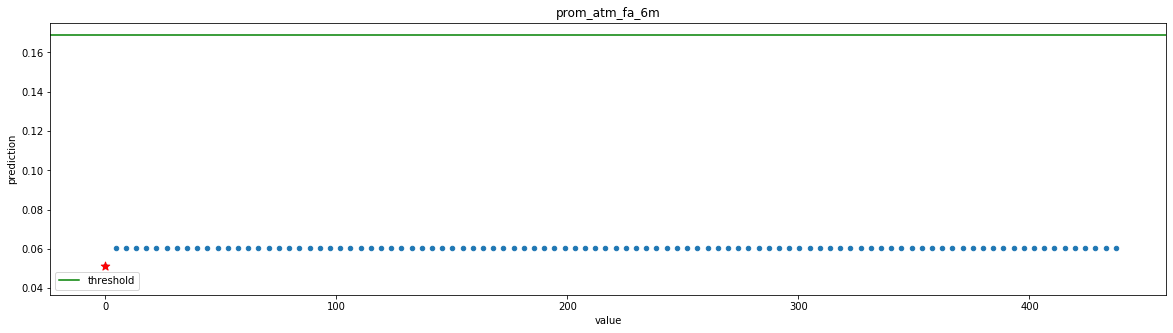

std_atm_fa_3m


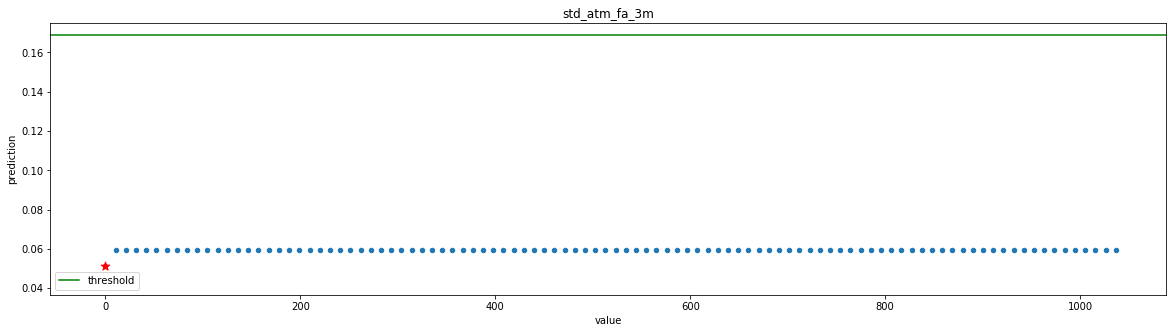

vari_atm_fp0_3m


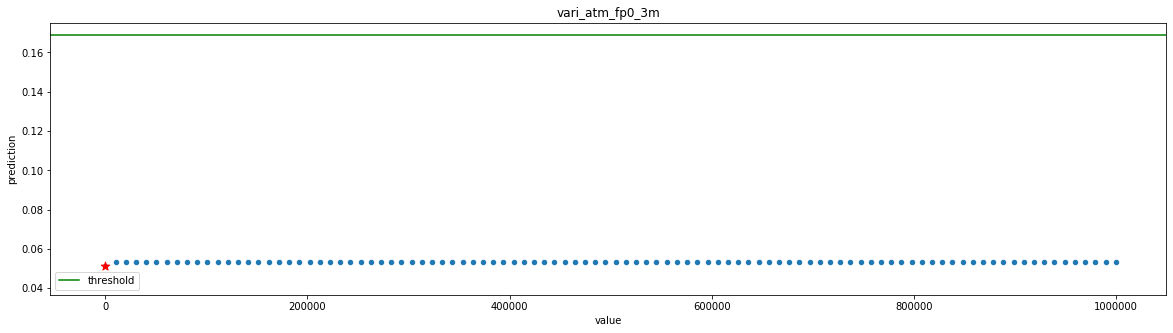

In [170]:
plot_variations_one(result_perturbation_cont, cont_cols, optimal_thresh_AUC_1)

atm_fa_cont


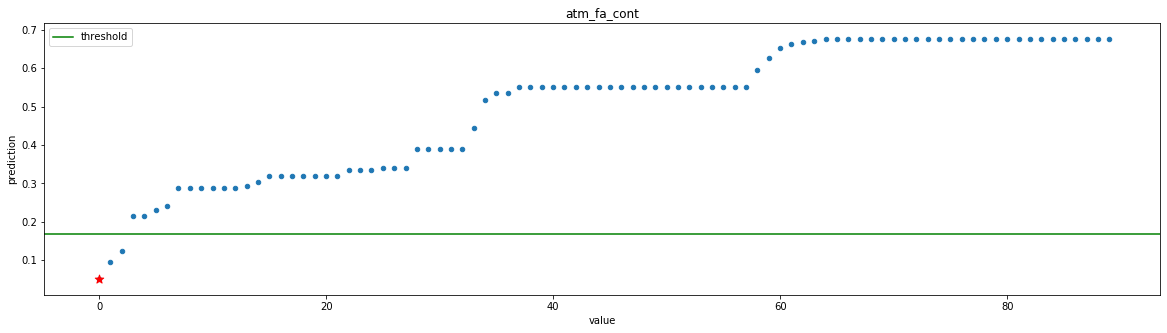

marca_huesped_pura


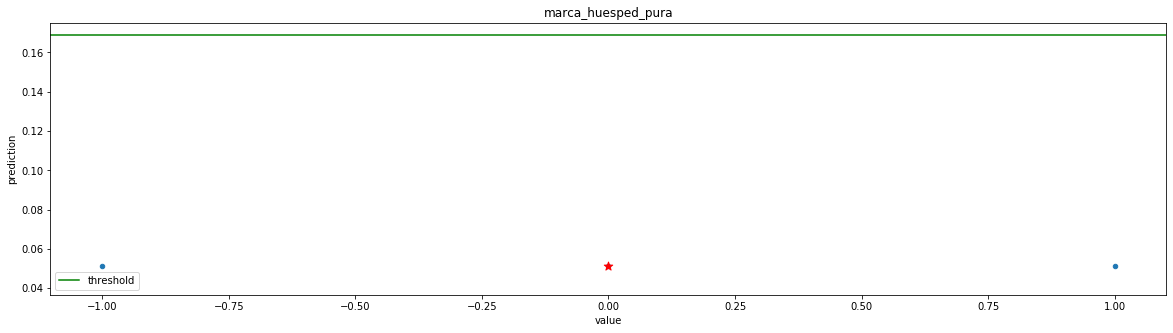

ddir_cliente


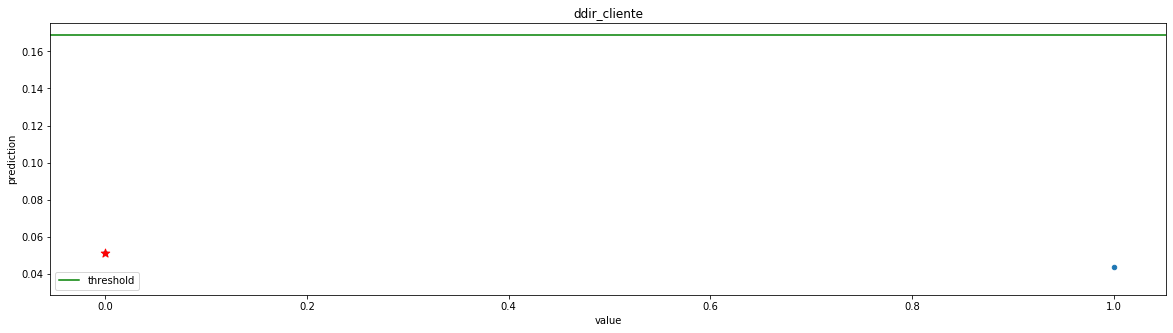

cnt_b2b


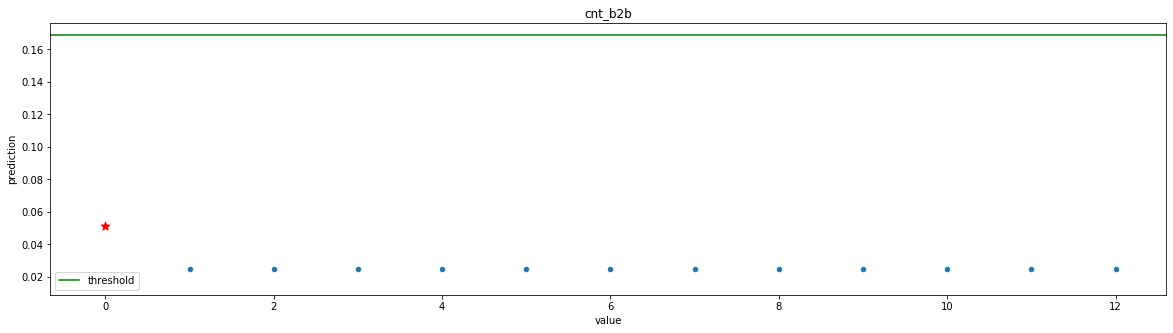

cnt_auto


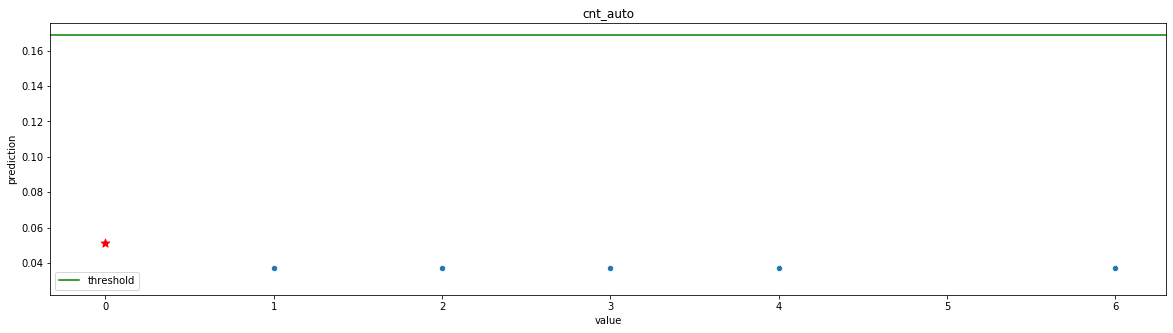

cnt_pp


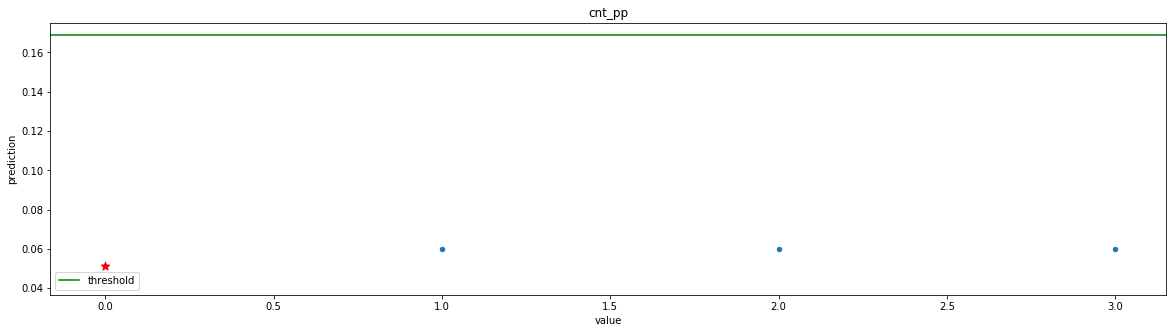

cnt_sob


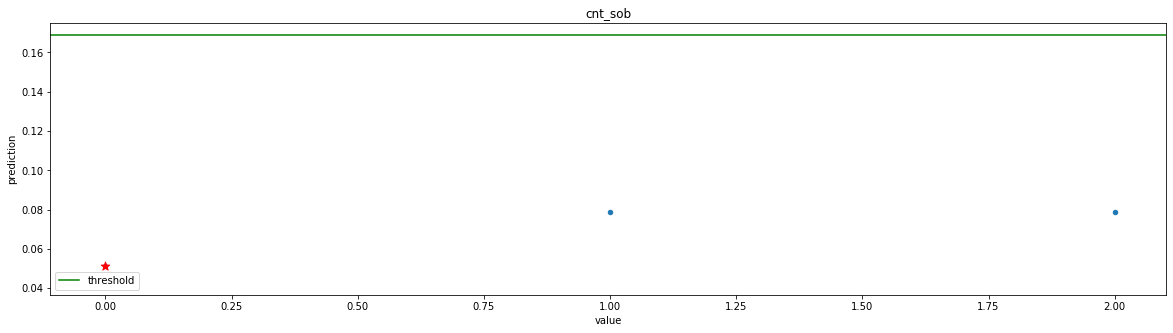

cnt_tdc


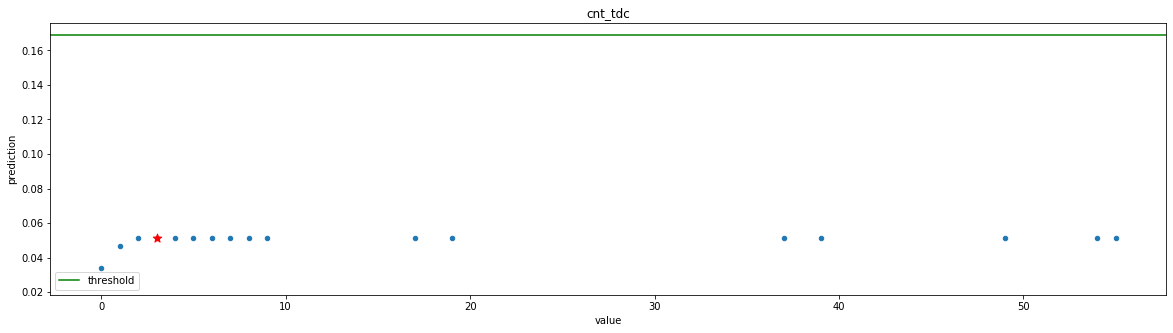

max_madurez_b2b


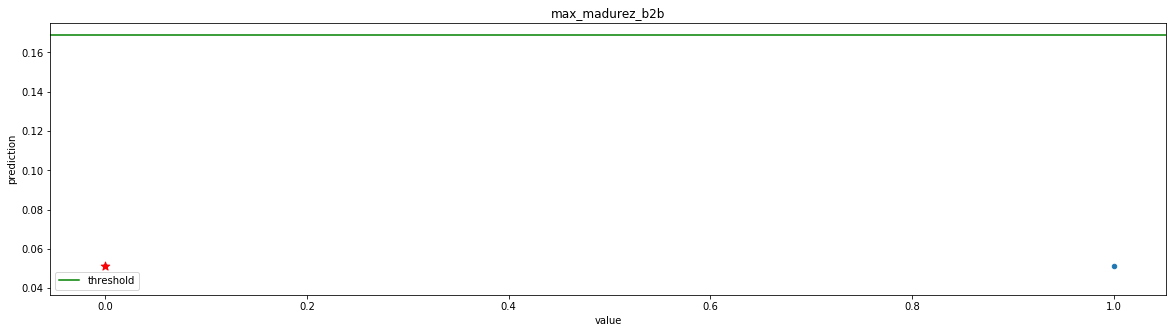

max_madurez_auto


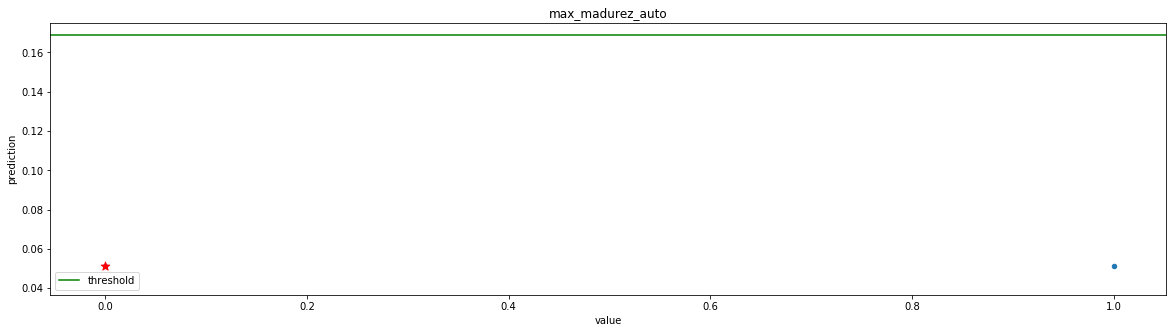

max_madurez_pp


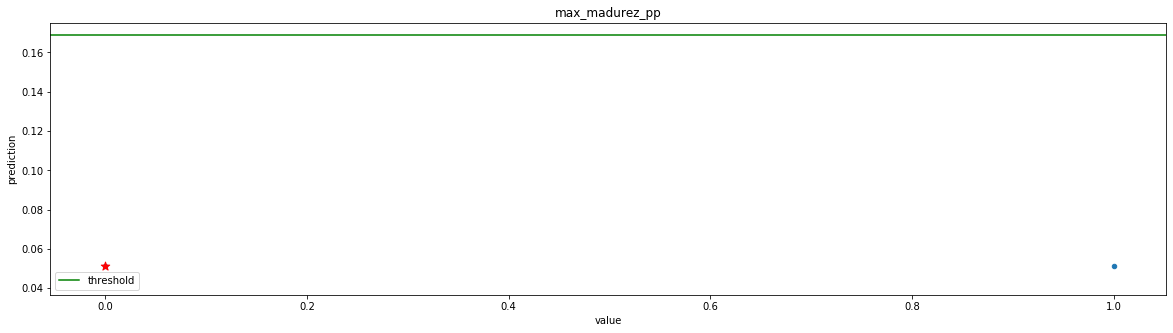

max_madurez_sob


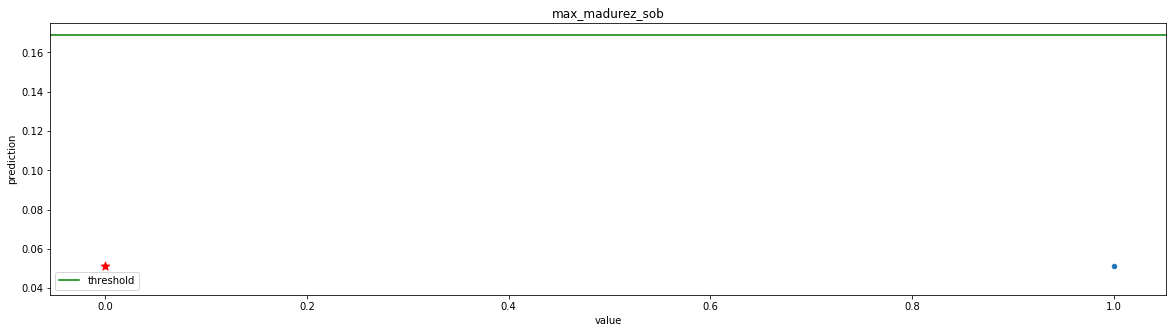

max_madurez_tdc


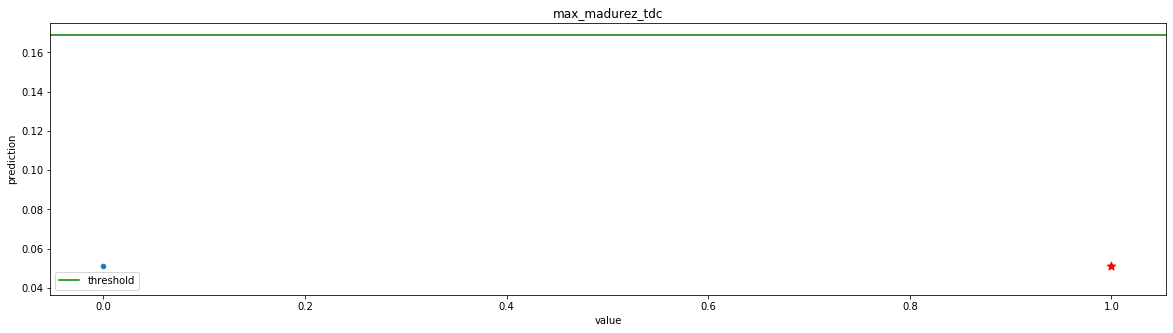

madurez


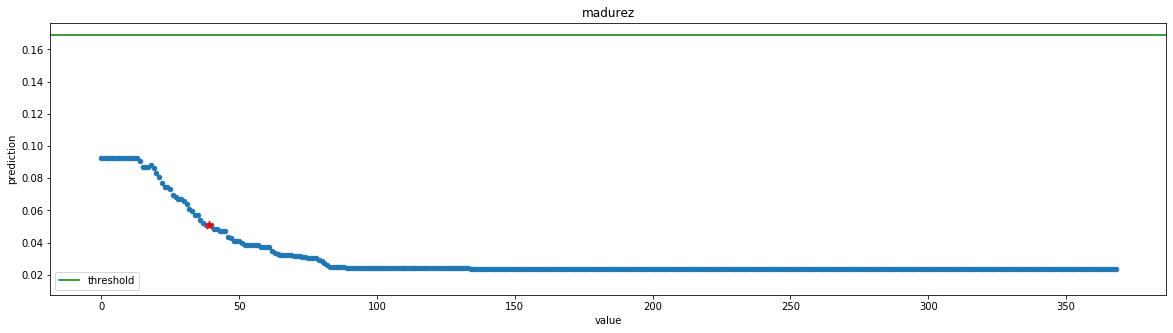

repr_rodamientos_12m


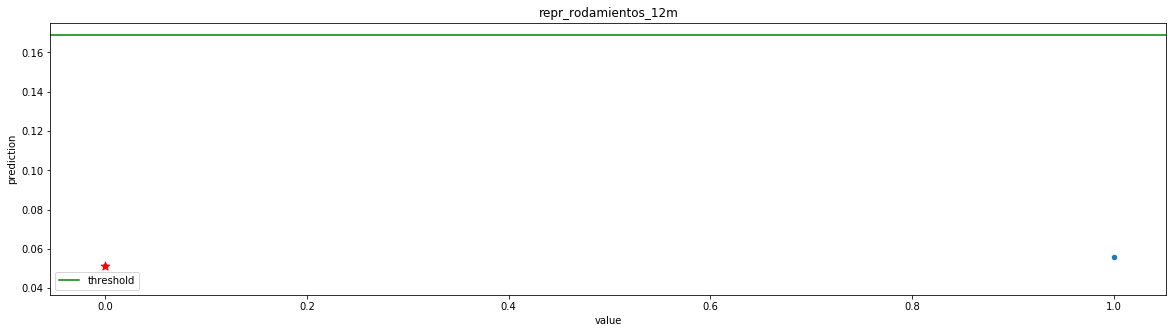

marca_rodamiento


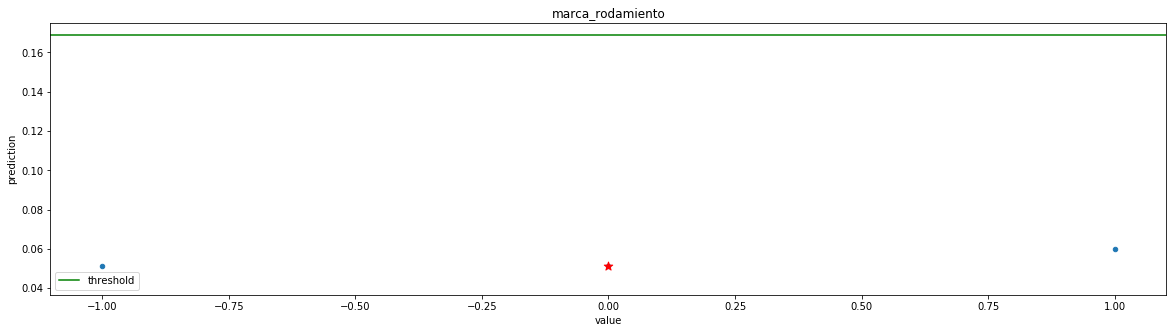

repr_ddir_cliente_12m


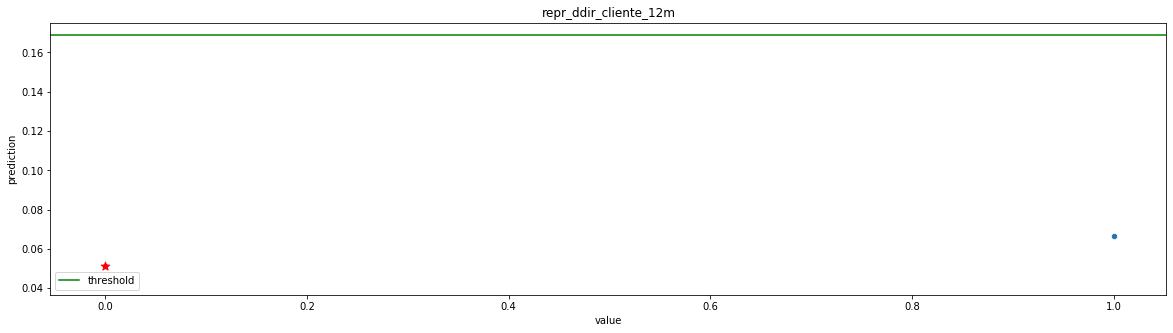

marca_mora_sup_61


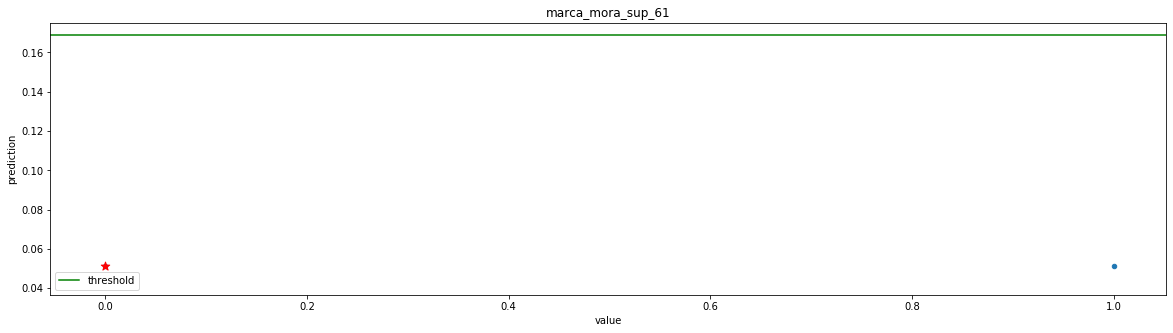

marca_perdio_ddir


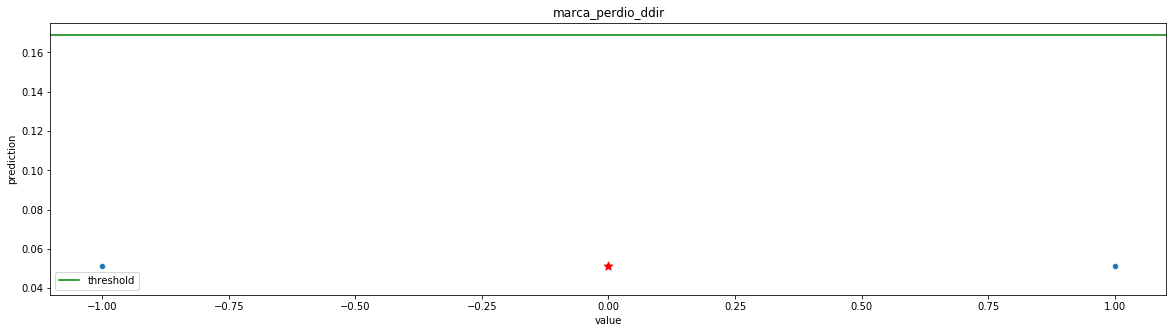

nonull_ult12


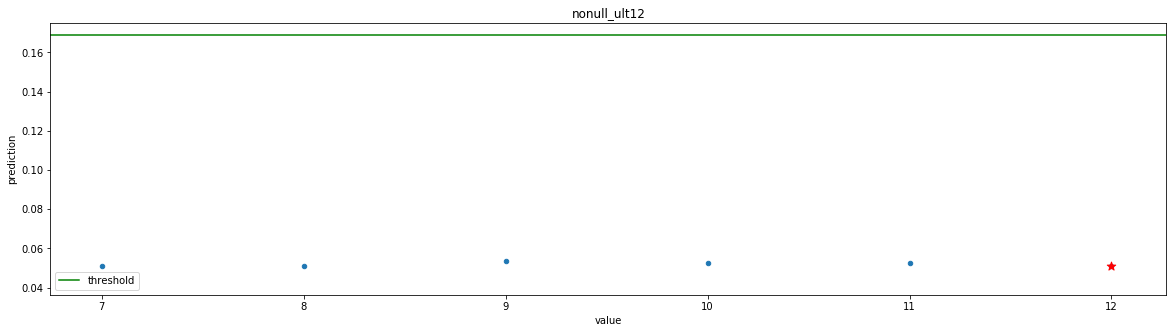

repr_mora_sup_61_12m


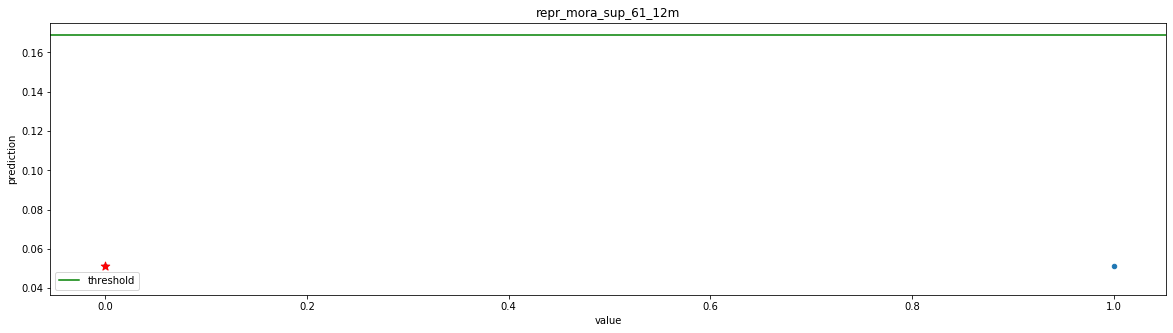

In [171]:
plot_variations_one(result_perturbation_cat, cat_cols, optimal_thresh_AUC_1)

# MEAN VARIABLE SENSITIVITY RESPONSE

In [172]:
def get_perturbations(model, dfbase, id_col, date_col, x_colnames, NSAMPLES, date_of_interest = None, filter_by_class = None):
    use_cols = [id_col,date_col,"default_90_12m"] + x_colnames
    if filter_by_class != None:
        df = dfbase[dfbase.default_90_12m == filter_by_class][use_cols]
    else:
        df = dfbase[use_cols].copy()
    
    eval_sample = df[id_col].value_counts()[df[id_col].value_counts() == 12].sample(NSAMPLES).index
    sample_df = df[df[id_col].isin(eval_sample)]
    cat_cols = df[x_colnames].select_dtypes("int64").columns
    cont_cols = df[x_colnames].select_dtypes(float).columns
    
    unique_cat_vals = list()
    for i in cat_cols:
        unique_cat_vals.append(df[i].unique()) 
    
    unique_cont_vals = list()
    for i in cont_cols:
        if df[i].min() == -999.0:
            unique_cont_vals.append((i, 0, df[i].max()))
        else:
            unique_cont_vals.append((i, df[i].min(), df[i].max()))    
 
    if date_of_interest != None:
        sample_df = sample_df[sample_df[date_col] == date_of_interest]
    
    result_pert_total = list()
    for index, row in sample_df.iterrows():
        single_record = row
        perturbed_predictions_cat = list()
        pred_row = single_record[x_colnames].copy()
        for col, vals in zip(cat_cols, unique_cat_vals):
            perturbed_predictions_cat.append((row[id_col],row[date_col],col, pred_row[col], "real", model.predict_proba(pred_row.values.reshape(1, -1) )[:,1][0]))
            for val in vals:
                pred_row[col] = val
                perturbed_predictions_cat.append((row[id_col],row[date_col], col, val, "fake", model.predict_proba(pred_row.values.reshape(1, -1) )[:,1][0]))
                pred_row[col] =  pred_row[col]
        for col, minval, maxval in unique_cont_vals:
            perturbed_predictions_cat.append((row[id_col],row[date_col],col, pred_row[col], "real", model.predict_proba(pred_row.values.reshape(1, -1) )[:,1][0]))
            vals = np.linspace(minval, maxval, 100)
            for val in vals:
                pred_row[col] = val
                perturbed_predictions_cat.append((row[id_col],row[date_col], col, val, "fake", model.predict_proba(pred_row.values.reshape(1, -1) )[:,1][0]))
                pred_row[col] =  pred_row[col]
        result_perturbation_cat = pd.DataFrame(perturbed_predictions_cat, columns=["id","fecha", "var_name", "value","type", "prediction"])
        result_pert_total.append(result_perturbation_cat)
        
    return pd.concat(result_pert_total, axis=0)



In [173]:
sensitivity_df = df_oot.copy()
sensitivity_df.repr_rodamientos_12m = sensitivity_df.repr_rodamientos_12m.astype("int64")
sensitivity_df.repr_ddir_cliente_12m = sensitivity_df.repr_ddir_cliente_12m.astype("int64")
sensitivity_df.repr_mora_sup_61_12m = sensitivity_df.repr_mora_sup_61_12m.astype("int64")

In [174]:
perturb_total = get_perturbations(model = best_model, 
                                  dfbase = sensitivity_df, 
                                  id_col = "id",
                                  date_col = "fecha", 
                                  x_colnames = x_oot_cols, 
                                  NSAMPLES = 10, 
                                  date_of_interest= "2018-12-01",
                                  filter_by_class = 1)

In [175]:
ranking_perturb = ((perturb_total[perturb_total.type =="fake"].groupby(["var_name", "value","type"])["prediction"].mean())).reset_index()

In [176]:
def plot_variations(df, cols, thresh):
    a = df[df.type =="fake"].groupby(["var_name", "value","type"])["prediction"].mean().reset_index()
    for col in cols:
        a[(a.var_name == col) & ( a.type =="fake")][["value", "prediction"]].plot.scatter("value", "prediction", figsize=(20,5))
        plt.title(col)
        plt.axhline(thresh, color="green", label="threshold")
        plt.legend()

In [177]:
ranking_perturb[ranking_perturb["type"]=="fake"].groupby("var_name").std().sort_values("prediction", ascending=False)

,value,prediction
var_name,,
atm_fa_cont,26.124701,0.148760
cnt_b2b,2.738613,0.039986
cnt_sob,1.000000,0.039032
madurez,105.455750,0.035162
cnt_tdc,17.245992,0.016172
max_madurez_auto,0.707107,0.014670
marca_rodamiento,1.000000,0.014500
ddir_cliente,0.707107,0.013658
std_atm_fa_3m,303.751437,0.012949


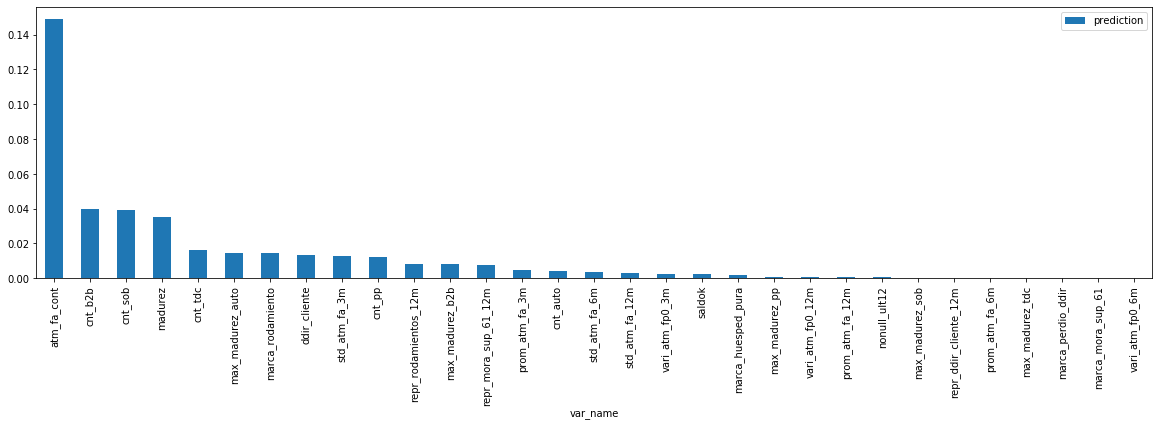

In [178]:
ranking_perturb[ranking_perturb["type"]=="fake"].groupby("var_name").std()[["prediction"]].sort_values( by="prediction",ascending=False).plot(kind="bar", figsize=(20,5))

C:\Users\eduperez\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_core.py:310: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


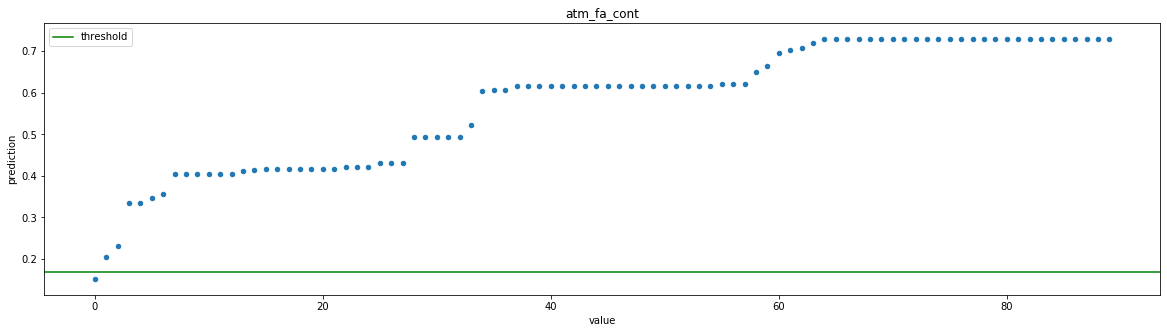

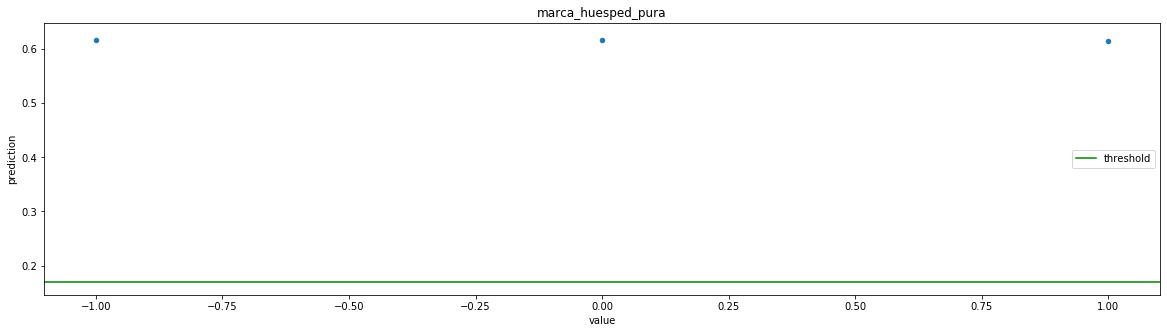

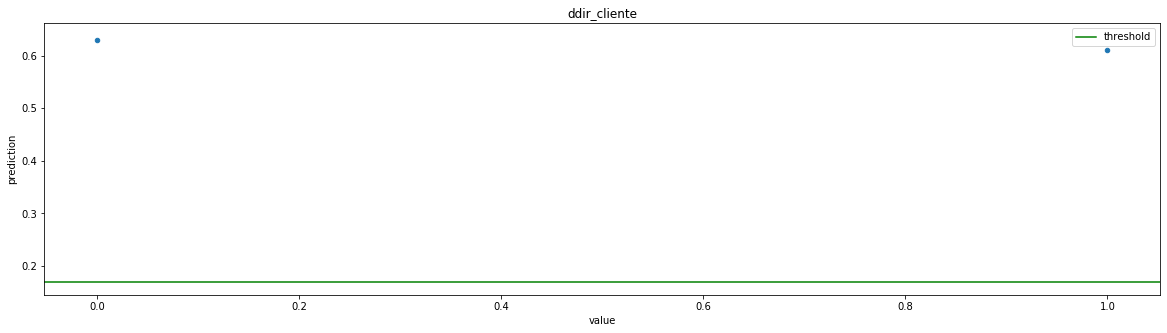

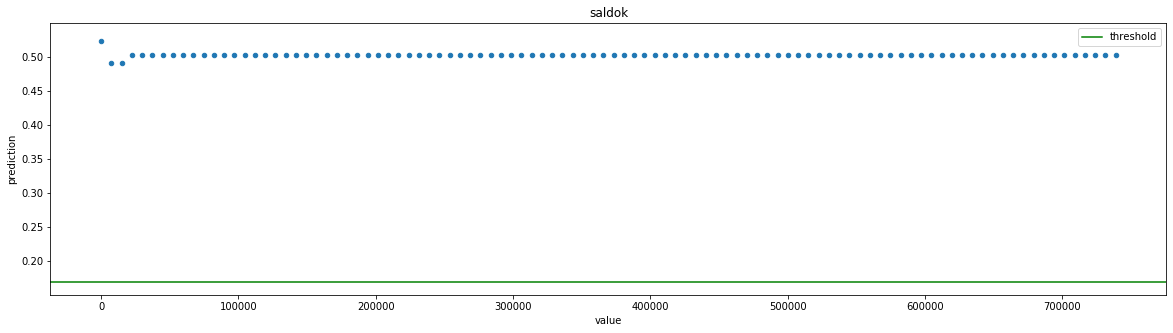

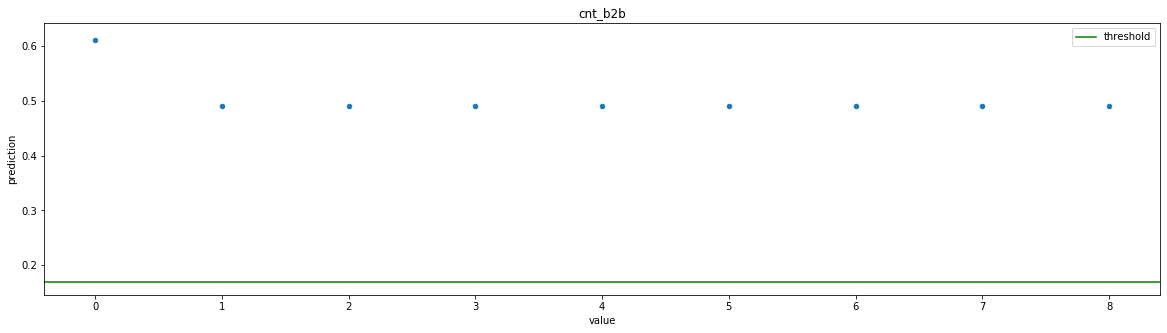

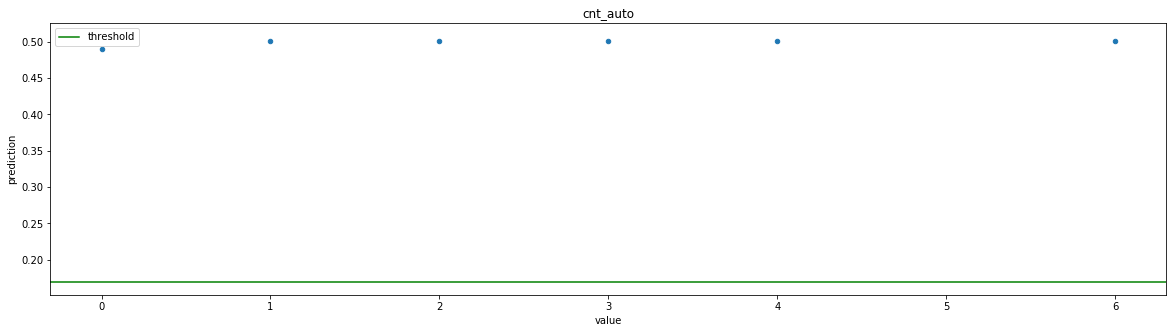

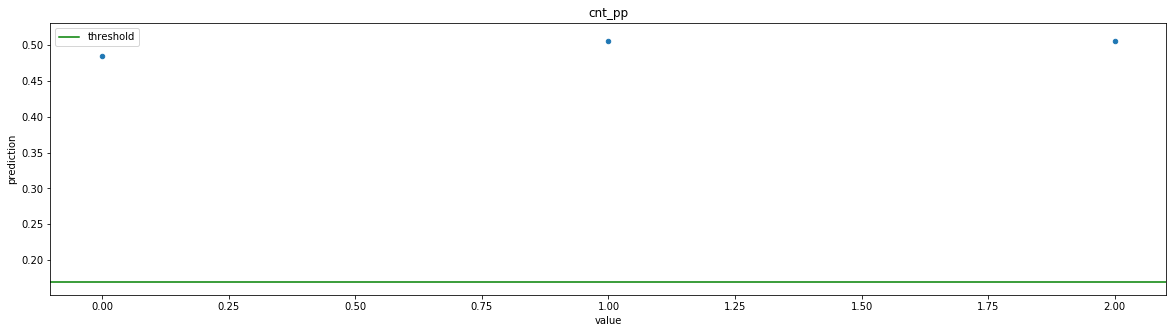

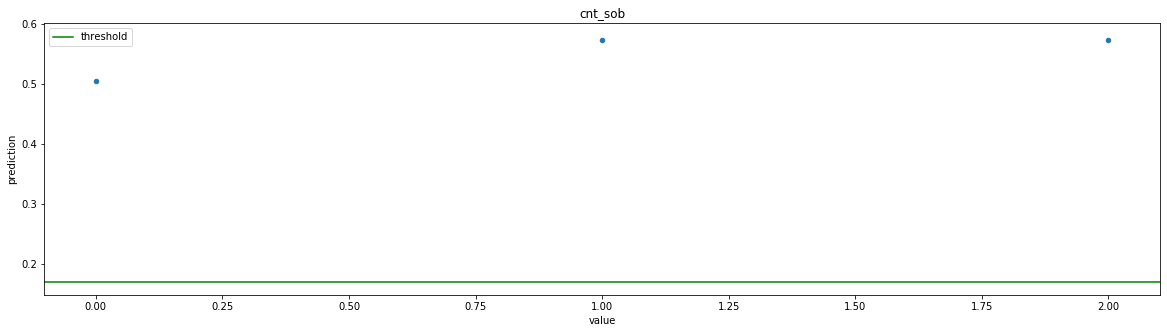

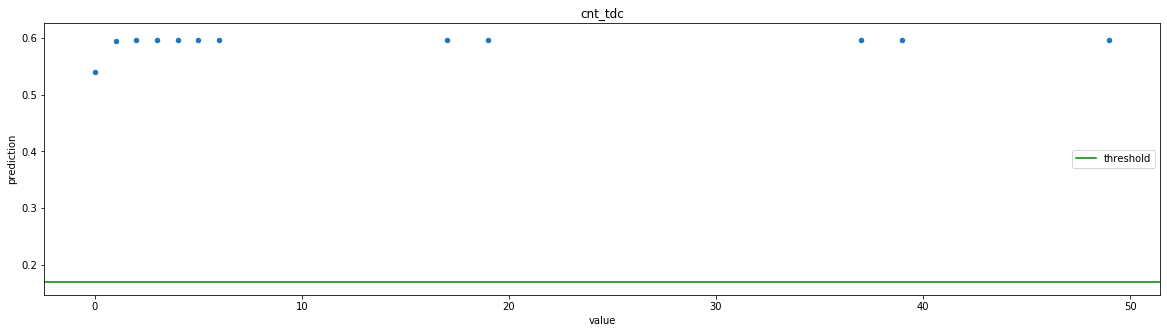

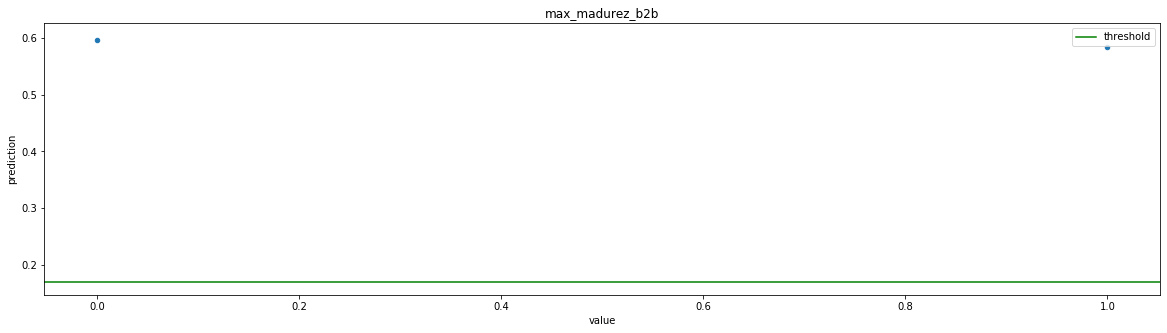

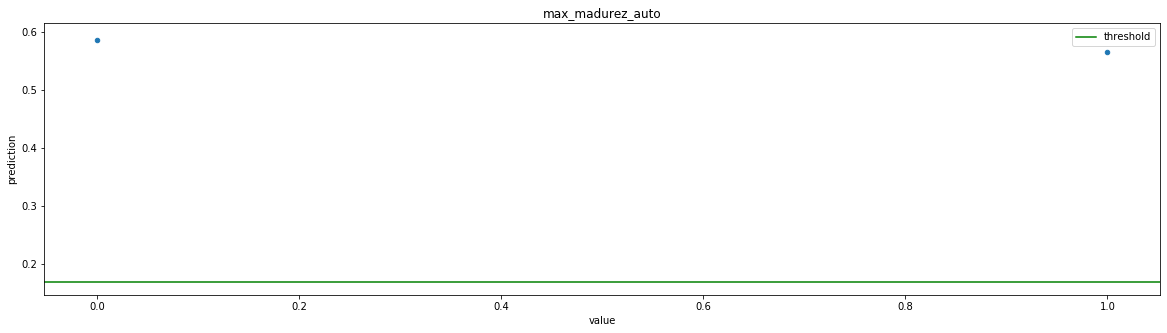

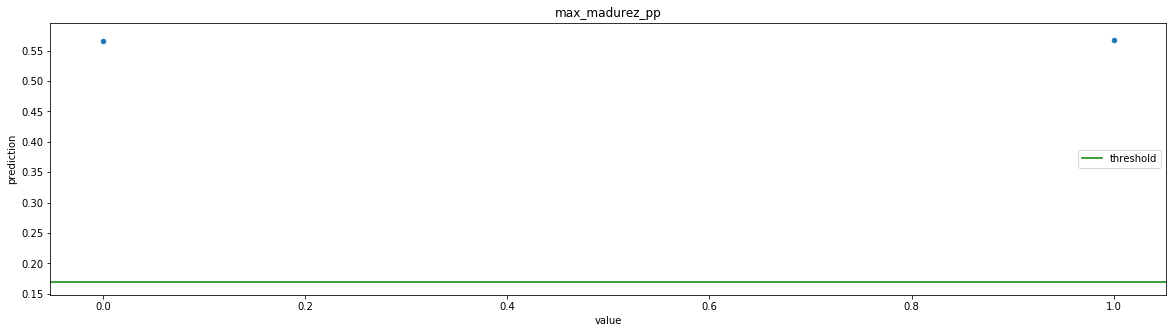

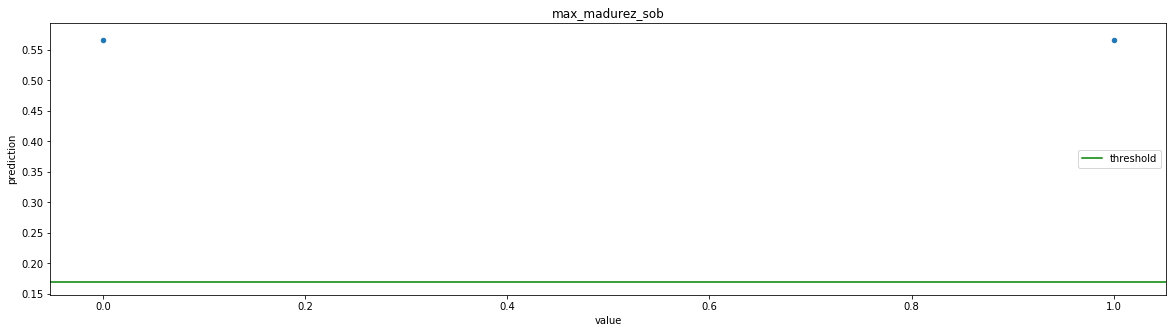

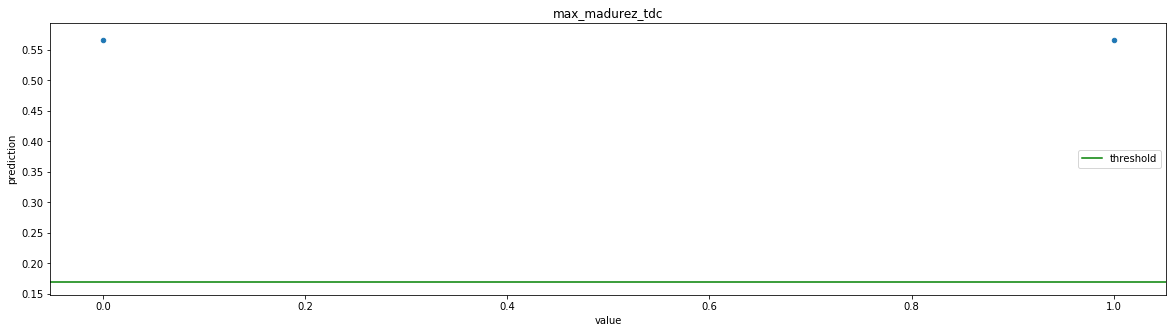

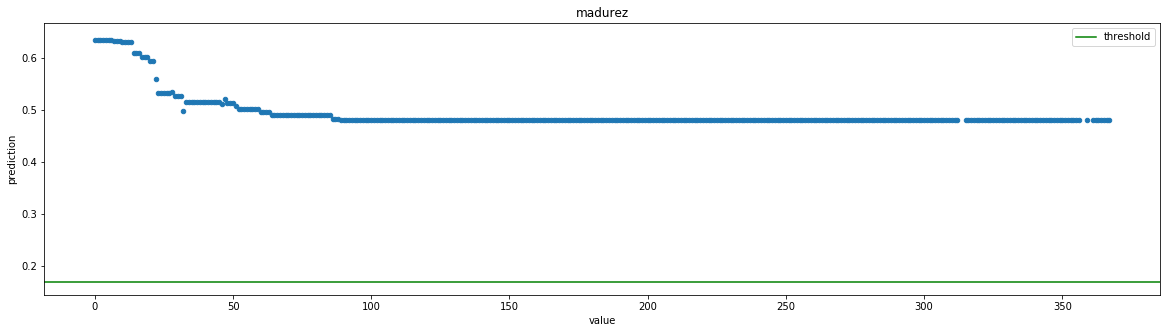

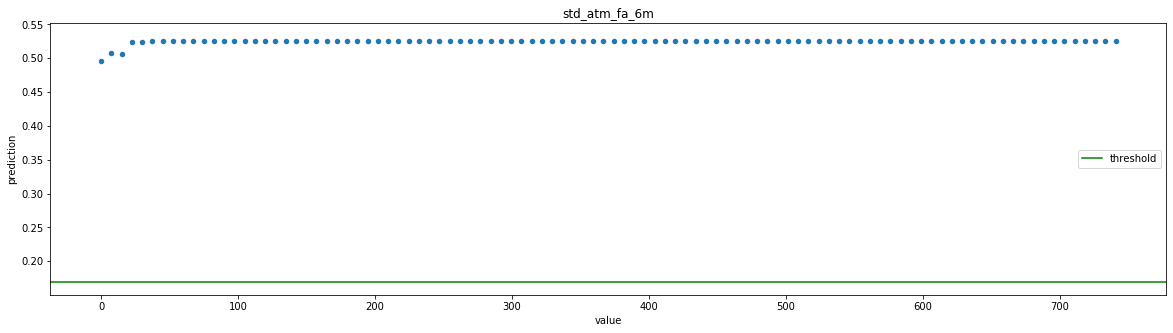

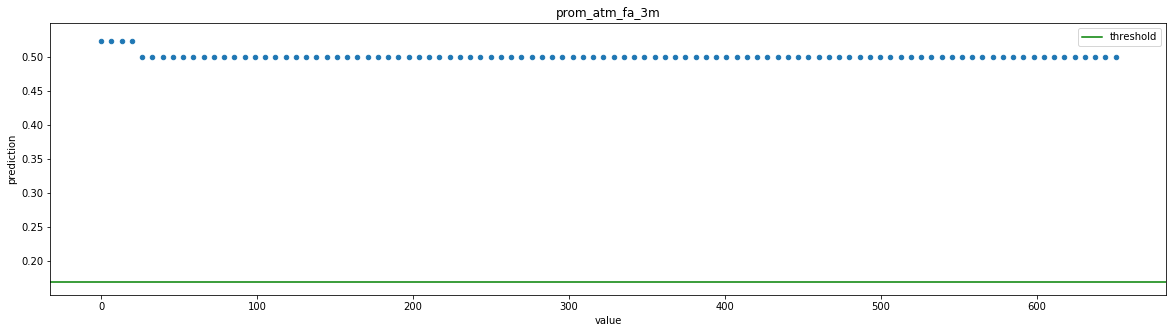

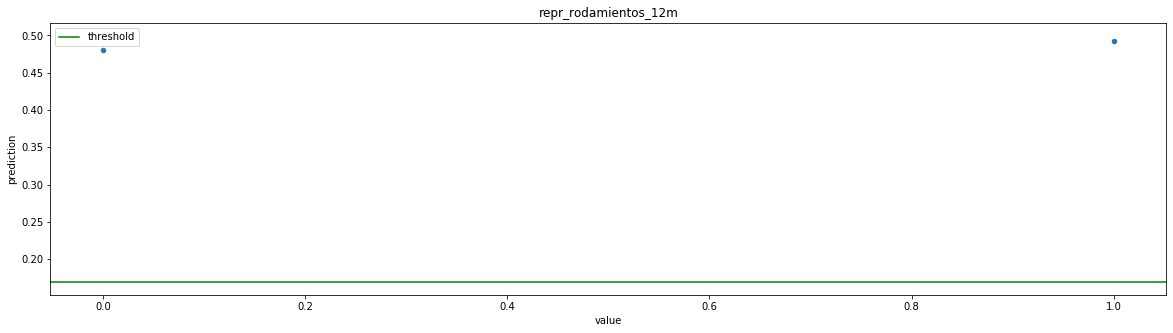

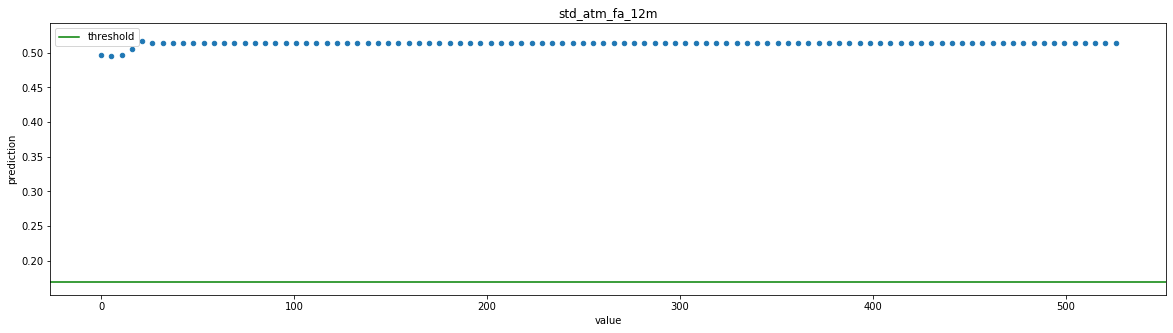

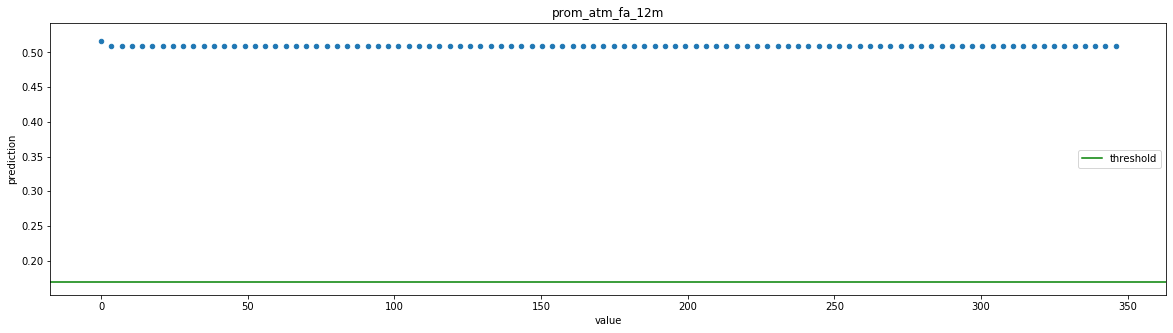

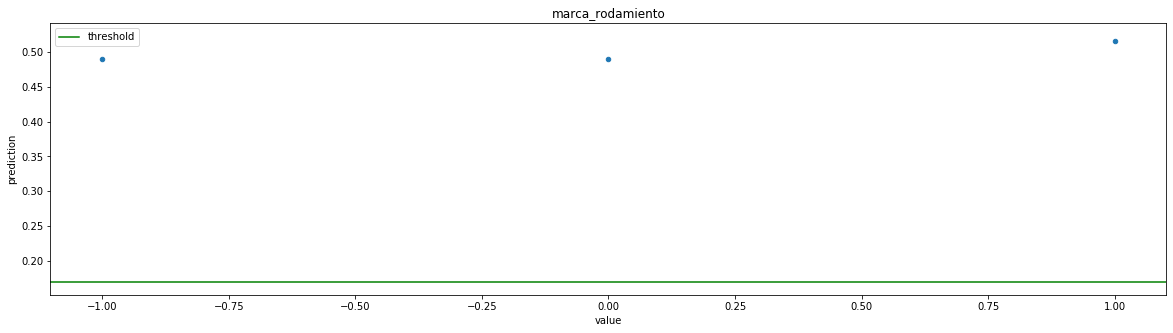

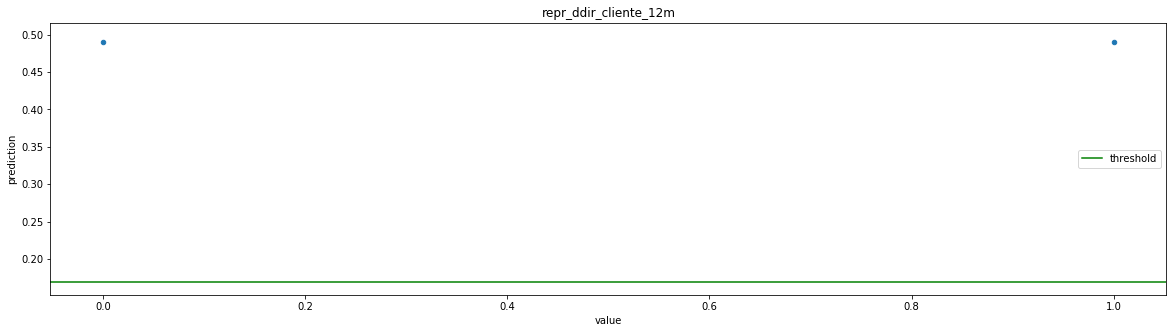

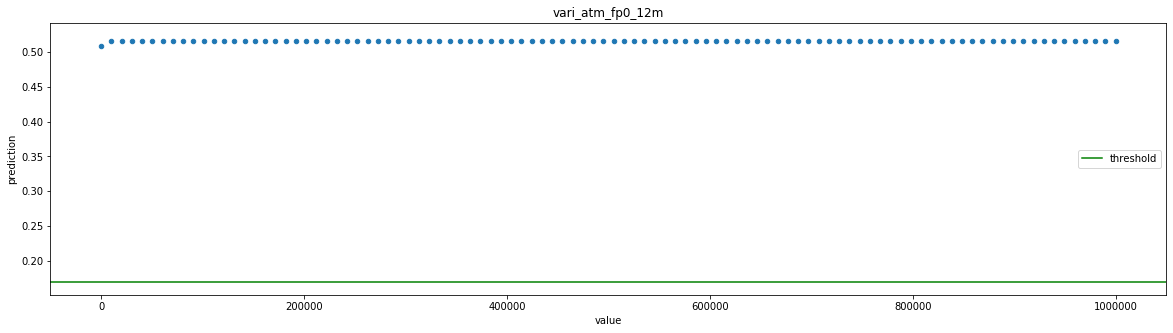

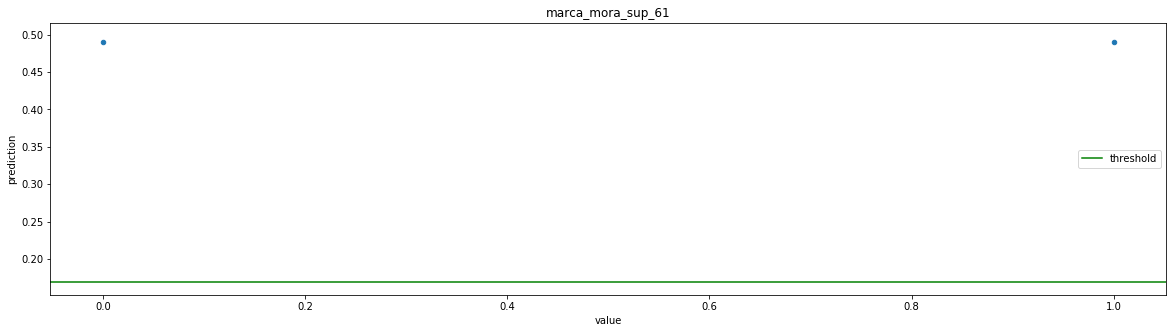

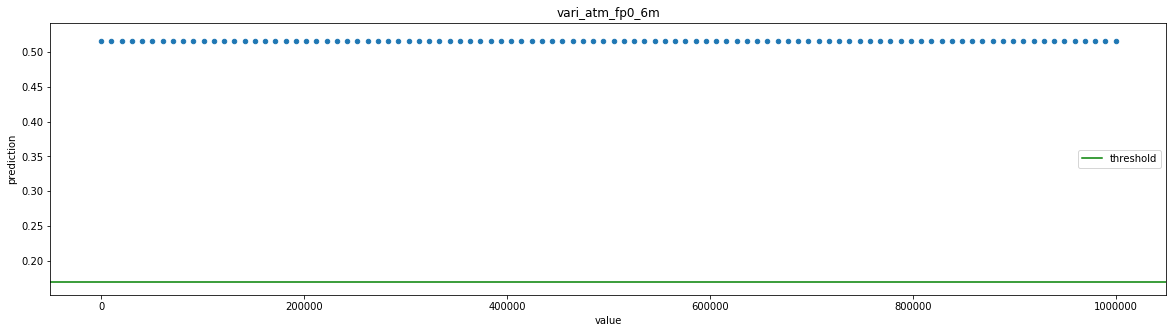

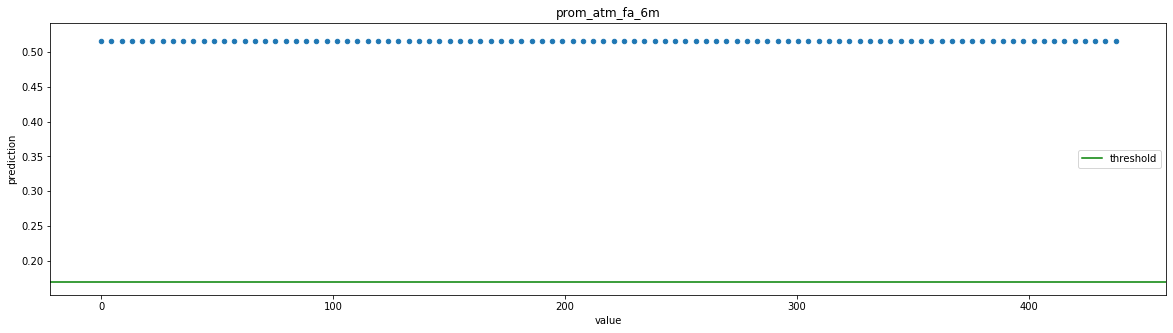

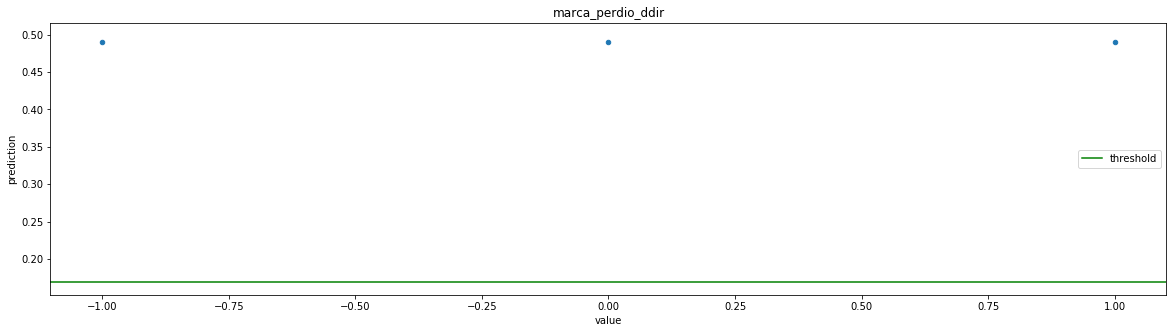

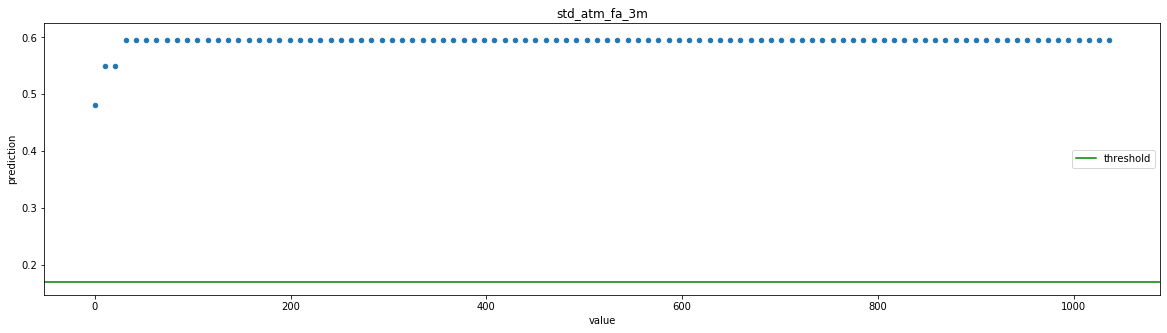

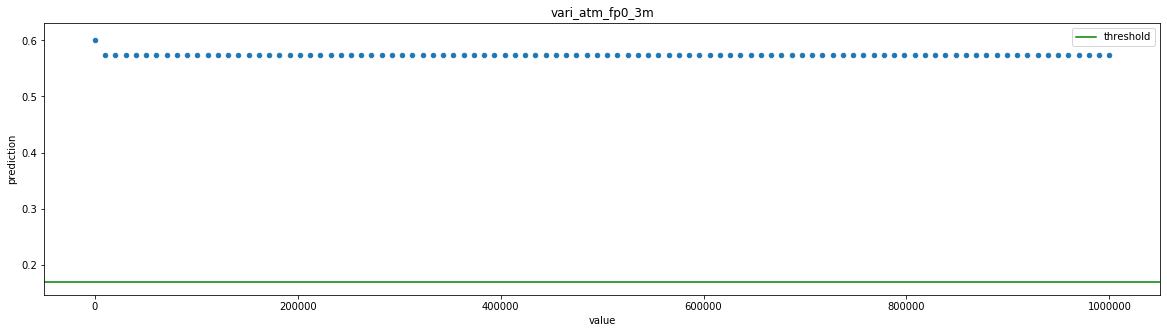

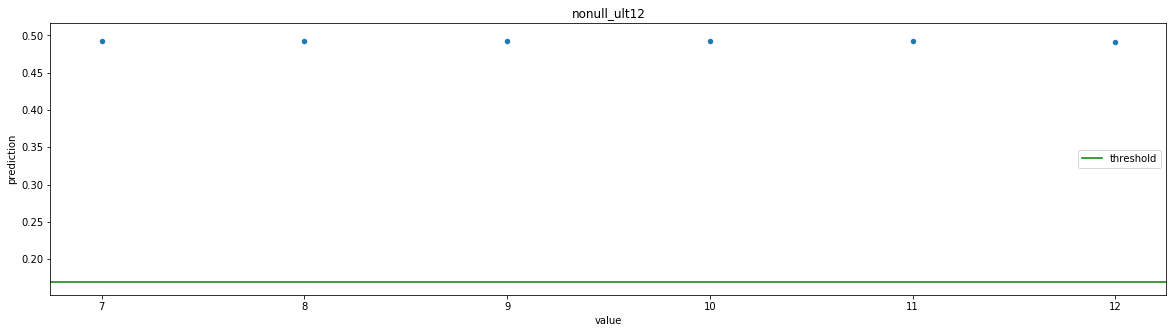

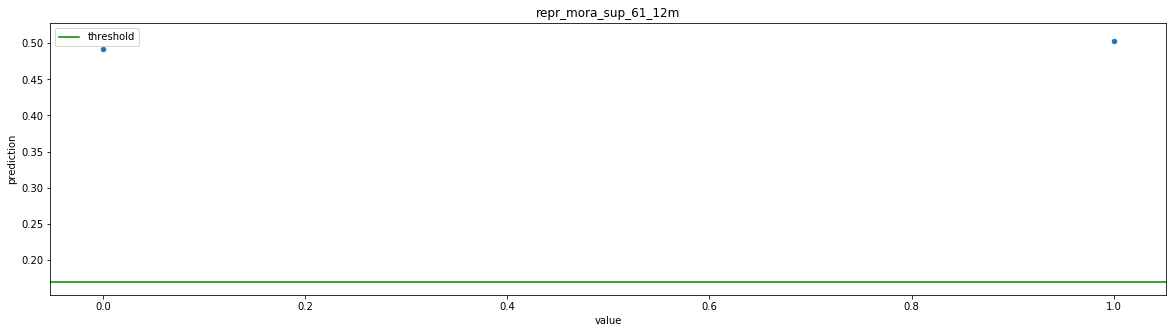

In [179]:
plot_variations(ranking_perturb, x_oot_cols, optimal_thresh_AUC_1)